# New Section

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from difflib import SequenceMatcher

from nltk.metrics import edit_distance, jaccard_distance
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score

from scipy.spatial.distance import hamming

def compute_syntactic_score(func1: str, func2: str, n_grams=2, hamming_mode='regular') -> float:
    # Calculate sequence similarity
    seq_matcher = SequenceMatcher(None, func1, func2, autojunk=False)
    sequence_similarity = seq_matcher.ratio()

    # Normalize the sequence similarity score
    sequence_similarity = (1 + sequence_similarity) / 2

    # Calculate the LCS similarity
    lcs = seq_matcher.find_longest_match(0, len(func1), 0, len(func2))
    lcs_similarity = lcs.size / max(len(func1), len(func2))

    # Calculate edit distance
    edit_distance_raw = edit_distance(func1, func2)
    edit_distance_score = 1 - edit_distance_raw / max(len(func1), len(func2))

    # Tokenize the code into words
    tokens1 = word_tokenize(func1)
    tokens2 = word_tokenize(func2)

    # Calculate Jaccard similarity
    jaccard_similarity = 1 - jaccard_distance(set(tokens1), set(tokens2))

    # Generate ngrams
    n_grams1 = [' '.join(n_gram) for n_gram in ngrams(tokens1, n_grams)]
    n_grams2 = [' '.join(n_gram) for n_gram in ngrams(tokens2, n_grams)]

    # Combine the ngrams into single strings
    ng_text1 = ' '.join(n_grams1)
    ng_text2 = ' '.join(n_grams2)

    # Calculate TF-IDF vectors
    vectorizer = TfidfVectorizer().fit([ng_text1, ng_text2])
    tfidf1 = vectorizer.transform([ng_text1])
    tfidf2 = vectorizer.transform([ng_text2])

    # Calculate cosine similarity
    cosine_similarity_score = cosine_similarity(tfidf1, tfidf2)[0, 0]

    # padding the codes for calculating Hamming Distance & Sørensen–Dice coefficient
    max_len = max(len(func1), len(func2))
    padded_func1 = func1.ljust(max_len)
    padded_func2 = func2.ljust(max_len)

    if hamming_mode == 'regular':
        # Calculate Hamming distance - Regular
        hamming_distance = hamming(list(padded_func1), list(padded_func2))
        hamming_distance_score = 1 - hamming_distance
    elif hamming_mode == 'sorted':
        # Calculate Hamming distance - Sorted
        hamming_distance = hamming(sorted(padded_func1), sorted(padded_func2))
        hamming_distance_score = 1 - hamming_distance

    # Calculate Sørensen–Dice coefficient (F1 score) - Need to binarize the padded strings
    binarized_func1 = [1 if char in padded_func2 else 0 for char in padded_func1]
    binarized_func2 = [1 if char in padded_func1 else 0 for char in padded_func2]
    sorensen_dice_coefficient = f1_score(binarized_func1, binarized_func2)

    # Return an aggregate similarity score and the scores for each metric
    scores = {
        "sequence_similarity": sequence_similarity,
        "edit_distance_score": edit_distance_score,
        "jaccard_similarity": jaccard_similarity,
        "cosine_similarity_score": cosine_similarity_score,
        "sorensen_dice_coefficient": sorensen_dice_coefficient,
        "hamming_distance_score": hamming_distance_score,
    }

    return sum(scores.values()) / len(scores), scores


def syntactic_similarity_driver(codes: list, n_grams=2, hamming_mode='regular') -> dict:
    scores = {}
    func1 = codes[0]
    funcList = codes[1:]
    for i, func2 in enumerate(funcList):
        score, metrics = compute_syntactic_score(func1, func2, n_grams, hamming_mode)
        scores[f"res_code_{i + 1}"] = {
            "aggregate_score": score,
            "metrics": metrics
        }
    return scores




In [ ]:
generated_codes = [
    '\ndef find_divisors(num):\n    divisors = []\n    for i in range(1, n + 1):\n        if n % i == 0:\n            divisors.append(i)\n    return divisors\n',
    '\ndef find_divisors(num):\n    divisors = []\n    for j in range(1, num + 1, 1):\n        if num % j == 0:\n            divisors.append(j)\n    return divisors\n',
    '\ndef find_divisors(num):\n    something = set()\n    for index in range(1, int(weird**0.5) + 1):\n        if not (weird % index != 0):\n            something.add(index)\n            something.add(weird // index)\n    return sorted(something)\n'
]

if __name__ == "__main__":
    ref_code = generated_codes[0]
    candidate_codes = generated_codes[1:]

    similarity_scores = syntactic_similarity_driver(generated_codes)

    print(similarity_scores)


{'res_code_1': {'aggregate_score': 0.8705180815784913, 'metrics': {'sequence_similarity': 0.978405315614618, 'edit_distance_score': 0.935064935064935, 'jaccard_similarity': 0.88, 'cosine_similarity_score': 0.9135002783911399, 'sorensen_dice_coefficient': 0.9901639344262295, 'hamming_distance_score': 0.525974025974026}}, 'res_code_2': {'aggregate_score': 0.5289404940230574, 'metrics': {'sequence_similarity': 0.8237597911227155, 'edit_distance_score': 0.5169491525423728, 'jaccard_similarity': 0.4722222222222222, 'cosine_similarity_score': 0.15303770302009742, 'sorensen_dice_coefficient': 0.9534368070953437, 'hamming_distance_score': 0.2542372881355932}}}


In [ ]:
similarity_scores

{'res_code_1': {'aggregate_score': 0.8705180815784913,
  'metrics': {'sequence_similarity': 0.978405315614618,
   'edit_distance_score': 0.935064935064935,
   'jaccard_similarity': 0.88,
   'cosine_similarity_score': 0.9135002783911399,
   'sorensen_dice_coefficient': 0.9901639344262295,
   'hamming_distance_score': 0.525974025974026}},
 'res_code_2': {'aggregate_score': 0.5289404940230574,
  'metrics': {'sequence_similarity': 0.8237597911227155,
   'edit_distance_score': 0.5169491525423728,
   'jaccard_similarity': 0.4722222222222222,
   'cosine_similarity_score': 0.15303770302009742,
   'sorensen_dice_coefficient': 0.9534368070953437,
   'hamming_distance_score': 0.2542372881355932}}}

In [ ]:
#dictionary to store the sum of each metric
metric_sums = {
    'sequence_similarity': 0,
    'edit_distance_score': 0,
    'jaccard_similarity': 0,
    'cosine_similarity_score': 0,
    'sorensen_dice_coefficient': 0,
    'hamming_distance_score': 0
}


num_entries = len(similarity_scores)

#getting the sum of each metric
for entry in similarity_scores.values():
    for metric, value in entry['metrics'].items():
        metric_sums[metric] += value


#compute the average for each metric
metric_averages = {metric: sum_value / num_entries for metric, sum_value in metric_sums.items()}

metric_averages


{'sequence_similarity': 1.8021651067373334, 'edit_distance_score': 1.4520140876073078, 'jaccard_similarity': 1.3522222222222222, 'cosine_similarity_score': 1.0665379814112372, 'sorensen_dice_coefficient': 1.9436007415215732, 'hamming_distance_score': 0.7802113141096192}


{'sequence_similarity': 0.9010825533686667,
 'edit_distance_score': 0.7260070438036539,
 'jaccard_similarity': 0.6761111111111111,
 'cosine_similarity_score': 0.5332689907056186,
 'sorensen_dice_coefficient': 0.9718003707607866,
 'hamming_distance_score': 0.3901056570548096}

# BertScore

In [ ]:
!pip install bert_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
ERROR: Operation cancelled by user


In [ ]:
from transformers import BertTokenizer, BertForMaskedLM, BertModel
from bert_score import BERTScorer

# Example texts
# reference = "This is a reference text example."
# candidate = "This is a candidate text example."
reference = "This code defines a function called longest that takes a list of strings as input. It returns the longest string in the list. If the input list is empty, it returns None. If there are multiple strings with the same maximum length, it returns the first one encountered in the list."
candidate = "The provided code defines a function longest that takes a list of strings as an input and returns the first string with the maximum length from that list. If the input list is empty, the function returns None."
reference =  "Given two strings s and t, return true if s is a subsequence of t, or false otherwise. A subsequence of a string is a new string that is formed from the original string by deleting some (can be none) of the characters without disturbing the relative positions of the remaining characters. (i.e., 'ace' is a subsequence of 'abcde' while 'aec' is not)." #"This code defines the longest function, which accepts a list of strings as input. The longest string in the list is returned. It yields None if the input list is empty. It returns the first string found in the list if there are several strings with the same maximum length." #"This code defines a function called longest that takes a list of strings as input. It returns the longest string in the list. If the input list is empty, it returns None. If there are multiple strings with the same maximum length, it returns the first one encountered in the list."
candidate = "The provided code defines a function longest that takes a list of strings as an input and returns the first string with the maximum length from that list. If the input list is empty, the function returns None."

# examples = [("The function longest finds and returns the lexicographically smallest string among the longest strings in a list. If the input list is empty, it returns None."
# ,"The provided code defines a function longest that takes a list of strings as an input and returns the first string with the maximum length from that list. If the input list is empty, the function returns None."),("This code defines a function named longest that takes a list of strings as input. It first checks if the list is empty and returns None if it is. Then, it finds the longest string in the list. Finally, it returns the shortest string among those with the same length as the longest string found.",
#              "This code defines a function called longest that takes a list of strings as input. It returns the longest string in the list. If the input list is empty, it returns None. If there are multiple strings with the same maximum length, it returns the first one encountered in the list.")]

# for ref, cand in examples:
#   print(ref, cand)


# BERTScore calculation
scorer = BERTScorer(model_type='bert-base-uncased', lang='en', rescale_with_baseline=True)
P, R, F1 = scorer.score([candidate], [reference],)
print(f"BERTScore Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

### Outputs : BERTScore Precision: 0.9258, Recall: 0.9258, F1: 0.9258

BERTScore Precision: 0.3616, Recall: 0.1926, F1: 0.2702


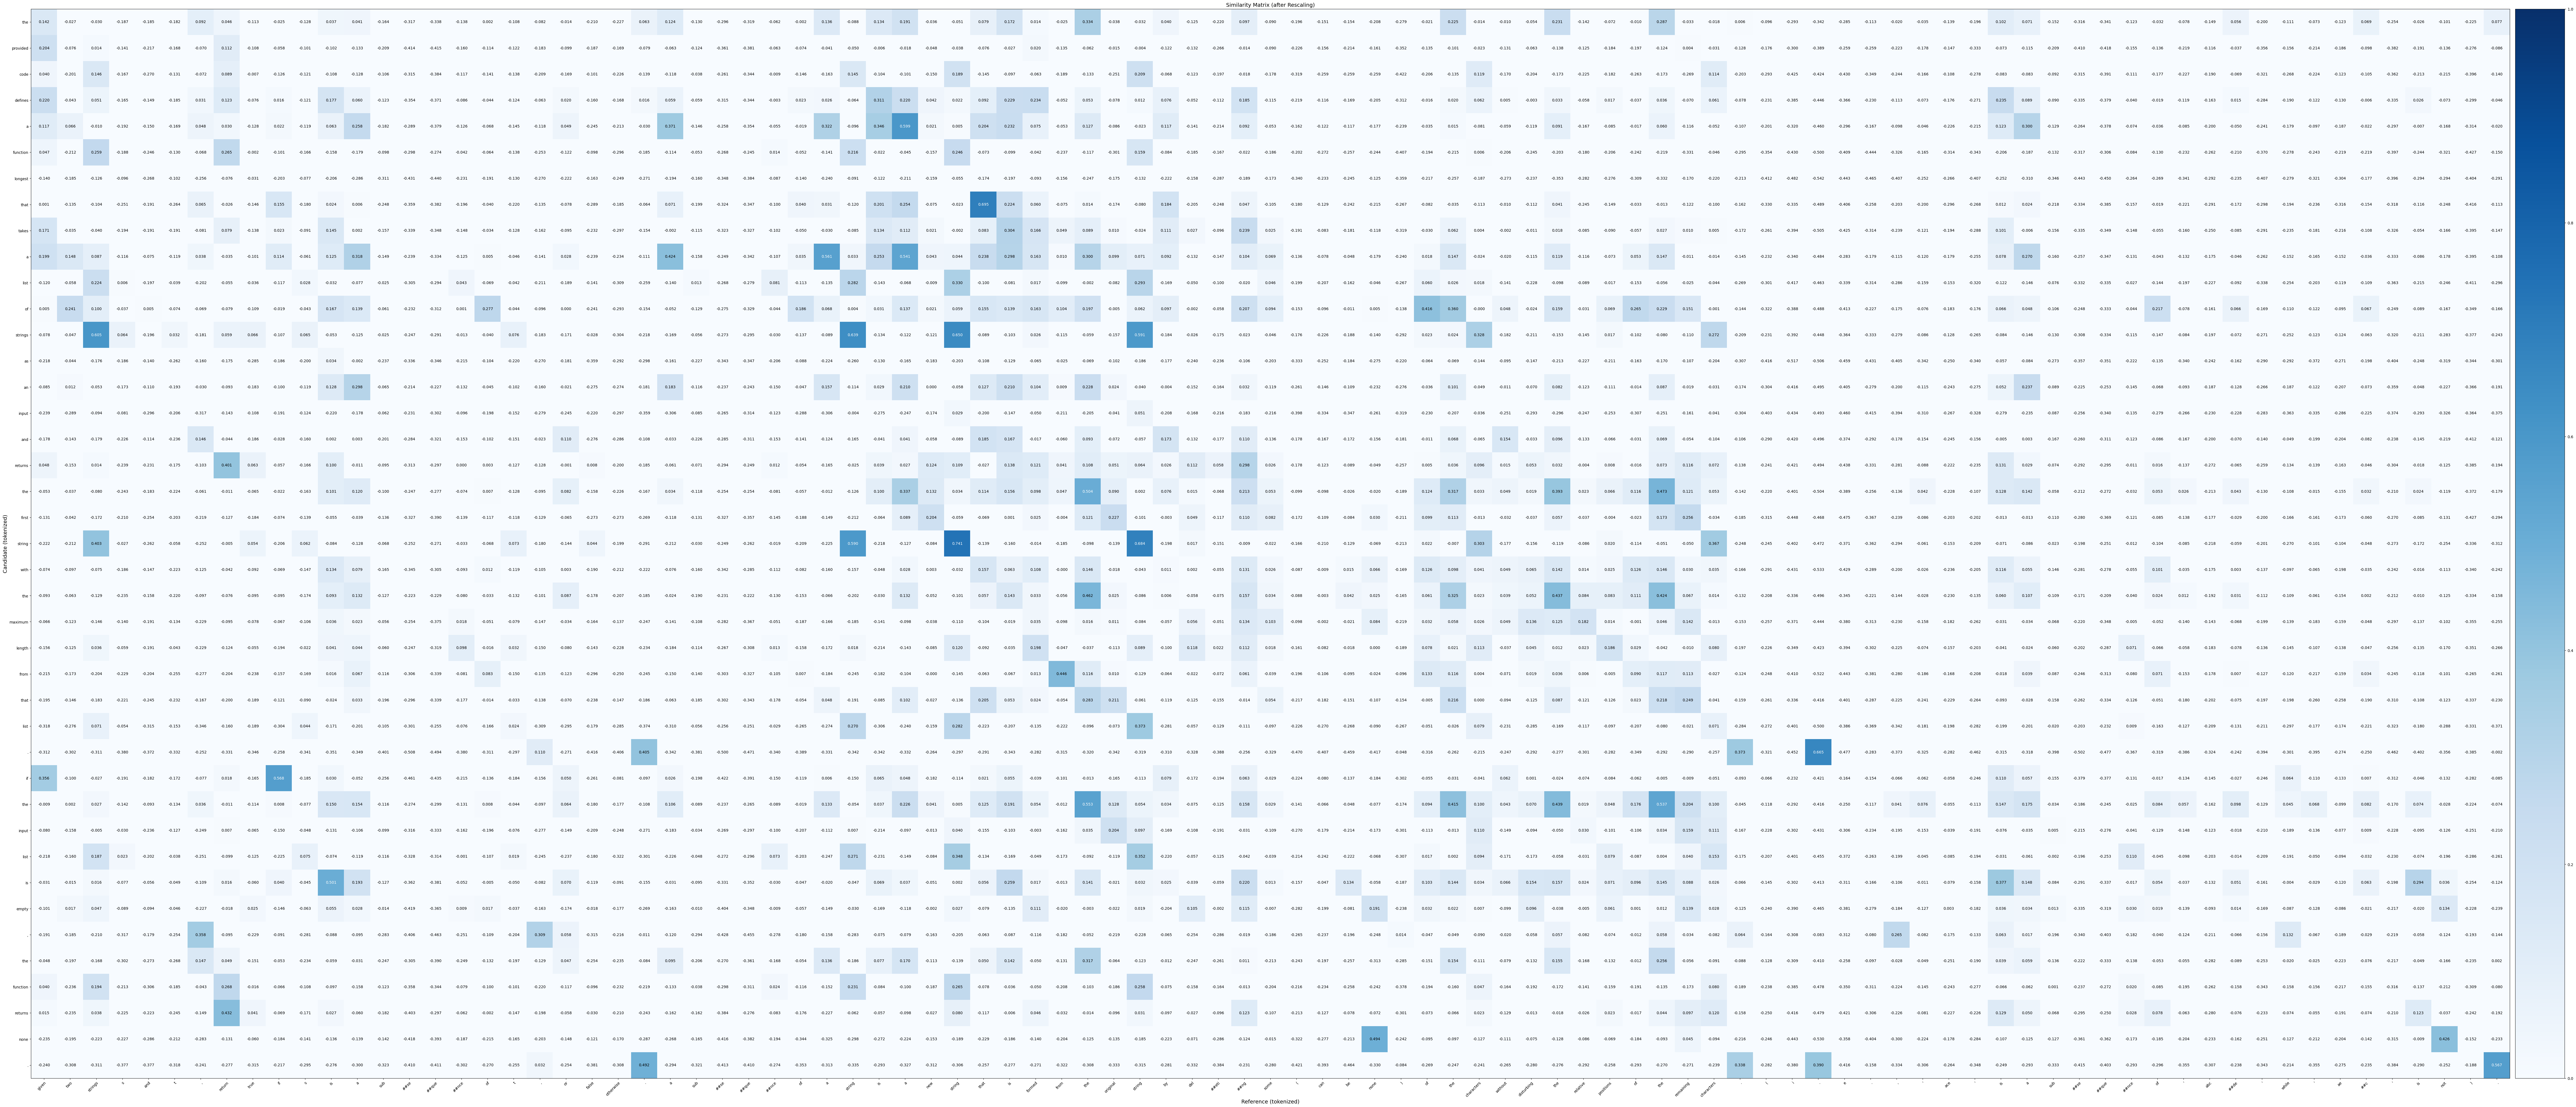

In [ ]:
scorer.plot_example(candidate,reference)

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Step 2: Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

# Step 3: Define the two texts to compare
# text1 = "This is an example text."
# text2 = "This text contains an example sentence."
text1 =  #"Determine if a 9 x 9 Sudoku board is valid. Only the filled cells need to be validated according to the following rules: Each row must contain the digits 1-9 without repetition. Each column must contain the digits 1-9 without repetition. Each of the nine 3 x 3 sub-boxes of the grid must contain the digits 1-9 without repetition. Note: A Sudoku board (partially filled) could be valid but is not necessarily solvable. Only the filled cells need to be validated according to the mentioned rules."
#"Given two strings s and t, return true if s is a subsequence of t, or false otherwise. A subsequence of a string is a new string that is formed from the original string by deleting some (can be none) of the characters without disturbing the relative positions of the remaining characters. (i.e., 'ace' is a subsequence of 'abcde' while 'aec' is not)." #"This code defines the longest function, which accepts a list of strings as input. The longest string in the list is returned. It yields None if the input list is empty. It returns the first string found in the list if there are several strings with the same maximum length." #"This code defines a function called longest that takes a list of strings as input. It returns the longest string in the list. If the input list is empty, it returns None. If there are multiple strings with the same maximum length, it returns the first one encountered in the list."
text2 = "The provided code defines a function longest that takes a list of strings as an input and returns the first string with the maximum length from that list. If the input list is empty, the function returns None."

# Step 4: Prepare the texts for BERT
inputs1 = tokenizer(text1, return_tensors="pt", padding=True, truncation=True)
inputs2 = tokenizer(text2, return_tensors="pt", padding=True, truncation=True)

# Step 5: Feed the texts to the BERT model
outputs1 = model(**inputs1)
outputs2 = model(**inputs2)

# Step 6: Obtain the representation vectors
embeddings1 = outputs1.last_hidden_state.mean(dim=1).detach().numpy()
embeddings2 = outputs2.last_hidden_state.mean(dim=1).detach().numpy()

# Step 7: Calculate cosine similarity
similarity = np.dot(embeddings1, embeddings2.T) / (np.linalg.norm(embeddings1) * np.linalg.norm(embeddings2))

# Step 8: Print the result
print("Similarity between the texts: {:.4f}".format(similarity[0][0]))

### Output: Similarity between the texts: 0.9000

Similarity between the texts: 0.7666


# MNLI


In [ ]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
import numpy as np

In [ ]:
sequence_to_classify = "one day I will see the world"
candidate_labels = ['travel', 'cooking', 'dancing']
result = classifier(sequence_to_classify, candidate_labels)
#{'labels': ['travel', 'dancing', 'cooking'],
# 'scores': [0.9938651323318481, 0.0032737774308770895, 0.002861034357920289],
# 'sequence': 'one day I will see the world'}

bestScoreIndex = np.argmax(result.get("scores"))
answer = result.get("labels")[bestScoreIndex]
answer

'travel'

In [ ]:
candidate_labels = ['travel', 'cooking', 'dancing', 'exploration']
result = classifier(sequence_to_classify, candidate_labels, multi_label=True)
#{'labels': ['travel', 'exploration', 'dancing', 'cooking'],
# 'scores': [0.9945111274719238,
#  0.9383890628814697,
#  0.0057061901316046715,
#  0.0018193122232332826],
# 'sequence': 'one day I will see the world'}

In [ ]:
result

{'sequence': 'one day I will see the world',
 'labels': ['travel', 'exploration', 'dancing', 'cooking'],
 'scores': [0.994511067867279,
  0.938388466835022,
  0.005706192459911108,
  0.001819293131120503]}

In [ ]:
# pose sequence as a NLI premise and label as a hypothesis
from transformers import AutoModelForSequenceClassification, AutoTokenizer
nli_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli')
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')


In [ ]:
premise =  "This code defines a function called longest that takes a list of strings as input. It returns the longest string in the list. If the input list is empty, it returns None. If there are multiple strings with the same maximum length, it returns the first one encountered in the list."
hypothesis = "The provided code defines a function longest that takes a list of strings as an input and returns the first string with the maximum length from that list. If the input list is empty, the function returns None."

# run through model pre-trained on MNLI
x = tokenizer.encode(premise, hypothesis, return_tensors='pt',
                     truncation_strategy='only_first')
logits = nli_model(x.to('cpu'))[0]

# we throw away "neutral" (dim 1) and take the probability of
# "entailment" (2) as the probability of the label being true
entail_contradiction_logits = logits[:,[0,2]]
probs = entail_contradiction_logits.softmax(dim=1)
prob_label_is_true = probs[:,1]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2709: FutureWarning: The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate the second sentence in the pairs) or `truncation='longest_first'` (will iteratively remove tokens from the longest sentence in the pairs).
  warnings.warn(


In [ ]:
prob_label_is_true

tensor([0.9986], grad_fn=<SelectBackward0>)

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")


from transformers import AutoModelForSequenceClassification, AutoTokenizer

nli_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli')
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')


def compute_semantic_score(comment1: str, comment2: str):
    premise =  comment1
    hypothesis = comment2

    # run through model pre-trained on MNLI
    x = tokenizer.encode(premise, hypothesis, return_tensors='pt',
                        truncation_strategy='only_first')
    logits = nli_model(x.to('cpu'))[0]

    # we throw away "neutral" (dim 1) and take the probability of
    # "entailment" (2) as the probability of the label being true
    entail_contradiction_logits = logits[:,[0,2]]
    probs = entail_contradiction_logits.softmax(dim=1)
    MNLI_Bart_score = probs[:,1]

    MNLI_Bart_score_numpy = float(MNLI_Bart_score.detach().numpy())


    # Step 3: Define the two texts to compare
    # text1 = "This is an example text."
    # text2 = "This text contains an example sentence."
    text1 = comment1
    text2 = comment2

    # Step 4: Prepare the texts for BERT
    inputs1 = bert_tokenizer(text1, return_tensors="pt", padding=True, truncation=True)
    inputs2 = bert_tokenizer(text2, return_tensors="pt", padding=True, truncation=True)

    # Step 5: Feed the texts to the BERT model
    outputs1 = bert_model(**inputs1)
    outputs2 = bert_model(**inputs2)

    # Step 6: Obtain the representation vectors
    embeddings1 = outputs1.last_hidden_state.mean(dim=1).detach().numpy()
    embeddings2 = outputs2.last_hidden_state.mean(dim=1).detach().numpy()

    # Step 7: Calculate cosine similarity
    bert_similarity_score = float(np.dot(embeddings1, embeddings2.T) / (np.linalg.norm(embeddings1) * np.linalg.norm(embeddings2)))



    # Return an aggregate similarity score and the scores for each metric
    scores = {
        'bert_score': bert_similarity_score,
        'MNLI_Bart' : MNLI_Bart_score_numpy
    }

    return sum(scores.values()) / len(scores), scores

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def semantics_similarity_driver(codes: list) -> dict:
    scores = {}
    comment1 = codes[0]
    commentsList = codes[1:]
    for i, comment2 in enumerate(commentsList):
        score, metrics = compute_semantic_score(
            comment1, comment2)
        scores["res_code_" + str(i + 1)] = {
            "aggregate_score": score,
            "metrics": metrics
        }

    # dictionary to store the sum of each metric
    metric_sums = {
        'bert_score': 0,
        'MNLI_Bart' : 0
    }

    num_entries = len(scores)

    # getting the sum of each metric
    for entry in scores.values():
        for metric, value in entry['metrics'].items():
            metric_sums[metric] += value

    # compute the average for each metric
    metric_averages = {metric: sum_value /
                       num_entries for metric, sum_value in metric_sums.items()}

    # getting the average of the metric averages
    average_metric_average = sum(
        metric_averages.values()) / len(metric_averages)

    return scores, metric_averages, average_metric_average

In [ ]:
generated_comments = [
    "This code defines a function called longest that takes a list of strings as input. It returns the longest string in the list. If the input list is empty, it returns None. If there are multiple strings with the same maximum length, it returns the first one encountered in the list.",
    "The provided code defines a function longest that takes a list of strings as an input and returns the first string with the maximum length from that list. If the input list is empty, the function returns None.",
    "This code defines the longest function, which accepts a list of strings as input. The longest string in the list is returned. It yields None if the input list is empty. It returns the first string found in the list if there are several strings with the same maximum length."
]
_, semantics_similarity_driver,_ = semantics_similarity_driver(generated_comments)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2709: FutureWarning: The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate the second sentence in the pairs) or `truncation='longest_first'` (will iteratively remove tokens from the longest sentence in the pairs).
  warnings.warn(
<ipython-input-25-41bf01ab4e89>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before p

In [ ]:
semantics_similarity_driver

{'bert_score': 0.9808202683925629, 'MNLI_Bart': 0.9991975128650665}

In [ ]:
dict = {}
for key in semantics_similarity_driver.keys():
    dict[key] = semantics_similarity_driver[key]


In [ ]:
print(dict)

{'bert_score': 0.9808202683925629, 'MNLI_Bart': 0.9991975128650665}


# Fekry:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import openpyxl

In [7]:
from transformers import BertTokenizer, BertModel
import torch

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")


from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DebertaV2ForSequenceClassification, DebertaV2Tokenizer


nli_model = DebertaV2ForSequenceClassification.from_pretrained('potsawee/deberta-v3-large-mnli')
nli_tokenizer = DebertaV2Tokenizer.from_pretrained('potsawee/deberta-v3-large-mnli')

nli_model.eval()
device = torch.device("cpu")
nli_model.to(device)

def compute_semantic_score(premise: str, hypothesis: str):
    # premise -> hypothesis?
    inputs = tokenizer.batch_encode_plus(
                    batch_text_or_text_pairs=[(hypothesis, premise)],
                    add_special_tokens=True, padding="longest",
                    truncation=True, return_tensors="pt",
                    return_token_type_ids=True, return_attention_mask=True,
                )
    inputs = inputs.to(device)
    logits = nli_model(**inputs).logits # neutral is already removed
    probs = torch.softmax(logits, dim=-1)
    MNLI_Bart_score = probs[0][1].item() # prob(contradiction)
    MNLI_Bart_score_numpy = 1 - MNLI_Bart_score


    # Step 3: Define the two texts to compare
    # text1 = "This is an example text."
    # text2 = "This text contains an example sentence."
    text1 = premise
    text2 = hypothesis

    # Step 4: Prepare the texts for BERT
    inputs1 = bert_tokenizer(text1, return_tensors="pt", padding=True, truncation=True)
    inputs2 = bert_tokenizer(text2, return_tensors="pt", padding=True, truncation=True)

    # Step 5: Feed the texts to the BERT model
    outputs1 = bert_model(**inputs1)
    outputs2 = bert_model(**inputs2)

    # Step 6: Obtain the representation vectors
    embeddings1 = outputs1.last_hidden_state.mean(dim=1).detach().numpy()
    embeddings2 = outputs2.last_hidden_state.mean(dim=1).detach().numpy()

    # Step 7: Calculate cosine similarity
    bert_similarity_score = float(np.dot(embeddings1, embeddings2.T) / (np.linalg.norm(embeddings1) * np.linalg.norm(embeddings2)))



    # Return an aggregate similarity score and the scores for each metric
    scores = {
        'bert_score': bert_similarity_score,
        'MNLI_Bart' : MNLI_Bart_score_numpy
    }

    return sum(scores.values()) / len(scores), scores

In [10]:
premise =  "The given Python code defines a function that takes a list of integers as input, sorts the list, and then creates a new list by alternately taking elements from the beginning and the end of the sorted list until all elements are processed. The new list is then returned as the output."
#hypothesis = "This code defines a function `strange_sort_list` that takes a list as input and returns a new list where the numbers are sorted in a specific manner. The numbers are first sorted in ascending order and then alternately taken from the beginning and end of the sorted list to form the final result list."
hypothesis= "This code defines a function that takes a list of integers as input, sorts the list in ascending order, and then rearranges the elements in a 'strange' way. The function returns a new list where the smallest number is followed by the largest number, then the second smallest number, followed by the second largest number, and so on until all elements are rearranged."
compute_semantic_score(premise = premise, hypothesis = hypothesis)

<ipython-input-7-2e283fd34a7b>:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bert_similarity_score = float(np.dot(embeddings1, embeddings2.T) / (np.linalg.norm(embeddings1) * np.linalg.norm(embeddings2)))


(0.9361341334879398,
 {'bert_score': 0.9448896050453186, 'MNLI_Bart': 0.9273786619305611})

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
commentsList = ["This code defines a function called longest that takes a list of strings as input. It returns the longest string in the list. If the input list is empty, it returns None. If there are multiple strings with the same maximum length, it returns the first one encountered in the list.", "This code defines a function called longest that takes a list of strings as input. It returns the longest string in the list. If the input list is empty, it returns None. If there are multiple strings with the same maximum length, it returns the first one encountered in the list."]

def temp(commentsList, mode = "splitted"):
    scores = {}
    comment1 = commentsList[0]
    commentsList = commentsList[1:]
    if mode == "splitted":
        for i, comment2 in enumerate(commentsList):
            sntnce_list = comment2.split(". ")
            avg_score = 0
            avg_metrics = {"bert_score": 0, "MNLI_Bart": 0}
            for j, comment_sntnce in enumerate(sntnce_list):
                score, metrics = compute_semantic_score(comment1, comment_sntnce)
                avg_score += score
                avg_metrics["bert_score"] += metrics["bert_score"]
                avg_metrics["MNLI_Bart"] += metrics["MNLI_Bart"]
            avg_score /= len(sntnce_list)
            avg_metrics["bert_score"] /= len(sntnce_list)
            avg_metrics["MNLI_Bart"] /= len(sntnce_list)

            scores["res_code_" + str(i + 1)] = {"aggregate_score": avg_score, "metrics": avg_metrics}
            return scores

scores = temp(commentsList)
scores

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'res_code_1': {'aggregate_score': 0.9384644661331549,
  'metrics': {'bert_score': 0.8932648003101349,
   'MNLI_Bart': 0.983664131956175}}}

In [ ]:
# mode: "whole" for normal comaprison, "splited" for splitted comparison
def semantics_similarity_driver(codes: list, mode="whole") -> dict:
    scores = {}
    comment1 = codes[0]
    commentsList = codes[1:]

    if mode == "whole":
        for i, comment2 in enumerate(commentsList):
            score, metrics = compute_semantic_score(premise = comment1, hypothesis = comment2)
            scores["res_code_" + str(i + 1)] = {"aggregate_score": score, "metrics": metrics}

    if mode == "splitted":
        for i, comment2 in enumerate(commentsList):
            sntnce_list = comment2.split(". ")
            avg_score = 0
            avg_metrics = {"bert_score": 0, "MNLI_Bart": 0}
            for j, comment_sntnce in enumerate(sntnce_list):
                score, metrics = compute_semantic_score(premise = comment1, hypothesis= comment_sntnce)
                avg_score += score
                avg_metrics["bert_score"] += metrics["bert_score"]
                avg_metrics["MNLI_Bart"] += metrics["MNLI_Bart"]
            avg_score /= len(sntnce_list)
            avg_metrics["bert_score"] /= len(sntnce_list)
            avg_metrics["MNLI_Bart"] /= len(sntnce_list)

            scores["res_code_" + str(i + 1)] = {"aggregate_score": avg_score, "metrics": avg_metrics}


    # dictionary to store the sum of each metric
    metric_sums = {
        # 'sequence_similarity': 0,
        # 'edit_distance_score': 0,
        # 'jaccard_similarity': 0,
        # 'cosine_similarity_score': 0,
        # 'sorensen_dice_coefficient': 0,
        # 'hamming_distance_score': 0,
        # 'longest_common_subsequence': 0
        'bert_score': 0,
        'MNLI_Bart' : 0
    }

    num_entries = len(scores)

    # getting the sum of each metric
    for entry in scores.values():
        for metric, value in entry['metrics'].items():
            metric_sums[metric] += value

    # compute the average for each metric
    metric_averages = {metric: sum_value /
                       num_entries for metric, sum_value in metric_sums.items()}

    # getting the average of the metric averages
    average_metric_average = sum(
        metric_averages.values()) / len(metric_averages)

    return scores, metric_averages, average_metric_average

In [ ]:
generated_comments = [
    "This code defines a function called longest that takes a list of strings as input. It returns the longest string in the list. If the input list is empty, it returns None. If there are multiple strings with the same maximum length, it returns the first one encountered in the list.",
    "The provided code defines a function longest that takes a list of strings as an input and returns the first string with the maximum length from that list. If the input list is empty, the function returns None.",
    "This code defines the longest function, which accepts a list of strings as input. The longest string in the list is returned. It yields None if the input list is empty. It returns the first string found in the list if there are several strings with the same maximum length."
]

generated_comments = [
    "This code defines a function called longest that takes a list of strings as input. It returns the longest string in the list. If the input list is empty, it returns None. If there are multiple strings with the same maximum length, it returns the first one encountered in the list.",
    "This code defines a function called longest that takes a list of strings as input. It returns the longest string in the list. If the input list is empty, it returns None. If there are multiple strings with the same maximum length, it returns the first one encountered in the list."
]
_, semantics_similarity,_ = semantics_similarity_driver(generated_comments)
semantics_similarity

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'bert_score': 1.0, 'MNLI_Bart': 0.9983175315428525}

In [ ]:
results = pd.read_csv('/content/results3.5_5_0_1.csv')
results.head()

,task_id,prompt,code_0,code_1,code_2,code_3,code_4,code_5,pass_rate_0,pass_rate_1,...,err_2,err_3,err_4,err_5,gpt-3.5-turbo_comment_0,gpt-3.5-turbo_comment_1,gpt-3.5-turbo_comment_2,gpt-3.5-turbo_comment_3,gpt-3.5-turbo_comment_4,gpt-3.5-turbo_comment_5
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,\nfrom typing import List\n\ndef has_close_ele...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\ndef has_close_ele...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\ndef has_close_ele...,100.0,100.0,...,NaN,NaN,NaN,NaN,This Python code defines a function `has_close...,This Python code defines a function `has_close...,This Python code defines a function that takes...,This Python code defines a function `has_close...,This code defines a function called `has_close...,This Python code defines a function `has_close...
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,\nfrom typing import List\n\n\ndef separate_pa...,\nfrom typing import List\n\ndef separate_pare...,\nfrom typing import List\n\ndef separate_pare...,\nfrom typing import List\n\ndef separate_pare...,\nfrom typing import List\n\n\ndef separate_pa...,\nfrom typing import List\n\n\ndef separate_pa...,100.0,0.0,...,NaN,NaN,NaN,NaN,This code defines a function to separate and r...,This Python code defines a function called `se...,The code defines a function that separates gro...,This Python function takes a string containing...,This code defines a function that takes a stri...,This Python code defines a function that separ...
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import modf\n\ndef truncate_number...,\nfrom math import floor\n\ndef truncate_numbe...,\ndef truncate_number(number: float) -> float:...,100.0,100.0,...,NaN,NaN,NaN,NaN,This Python code defines a function that takes...,This code defines a function called `truncate_...,This Python code defines a function called `tr...,This Python code defines a function `truncate_...,This Python code defines a function named `tru...,This Python function takes a float number as i...
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,100.0,100.0,...,NaN,NaN,NaN,NaN,This Python code defines a function called `be...,This code defines a function called `below_zer...,The code checks if the cumulative sum of a lis...,This Python function determines if the running...,This Python function checks if the cumulative ...,This Python code defines a function called `be...
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\n\ndef mean_absolu...,\nfrom typing import List\n\ndef mean_absolute...,100.0,100.0,...,NaN,NaN,NaN,NaN,This code defines a function `mean_absolute_de...,This Python code defines a function called `me...,This Python code defines a function `mean_abso...,This Python code defines a function called `me...,This Python code defines a function called `me...,This Python code defines a function that calcu...


In [ ]:
results = results.drop(['prompt'], axis=1)
results = results.drop([f'code_{i}' for i in range(6)], axis=1)
results = results.drop([f'err_{i}' for i in range(6)], axis=1)
results["avg_pass_rate"] = results[[f'pass_rate_{i}' for i in range(6)]].sum(axis=1)/6
results = results.drop([f'pass_rate_{i}' for i in range(6)], axis=1)
results.head()

,task_id,gpt-3.5-turbo_comment_0,gpt-3.5-turbo_comment_1,gpt-3.5-turbo_comment_2,gpt-3.5-turbo_comment_3,gpt-3.5-turbo_comment_4,gpt-3.5-turbo_comment_5,avg_pass_rate
0,HumanEval/0,This Python code defines a function `has_close...,This Python code defines a function `has_close...,This Python code defines a function that takes...,This Python code defines a function `has_close...,This code defines a function called `has_close...,This Python code defines a function `has_close...,100.000000
1,HumanEval/1,This code defines a function to separate and r...,This Python code defines a function called `se...,The code defines a function that separates gro...,This Python function takes a string containing...,This code defines a function that takes a stri...,This Python code defines a function that separ...,83.333333
2,HumanEval/2,This Python code defines a function that takes...,This code defines a function called `truncate_...,This Python code defines a function called `tr...,This Python code defines a function `truncate_...,This Python code defines a function named `tru...,This Python function takes a float number as i...,100.000000
3,HumanEval/3,This Python code defines a function called `be...,This code defines a function called `below_zer...,The code checks if the cumulative sum of a lis...,This Python function determines if the running...,This Python function checks if the cumulative ...,This Python code defines a function called `be...,100.000000
4,HumanEval/4,This code defines a function `mean_absolute_de...,This Python code defines a function called `me...,This Python code defines a function `mean_abso...,This Python code defines a function called `me...,This Python code defines a function called `me...,This Python code defines a function that calcu...,100.000000


In [ ]:
temp_df = pd.DataFrame(columns=["task_id", "comments_BERT_whole", "comments_BERT_splitted", "comments_MNLI_whole", "comments_MNLI_splitted"])
temp_df

,task_id,comments_BERT_whole,comments_BERT_splitted,comments_MNLI_whole,comments_MNLI_splitted


In [ ]:
# {'bert_score': 0.9808202683925629, 'MNLI_Bart': 0.9991975128650665}
BERT_whole = []
BERT_splitted = []
MNLI_whole = []
MNLI_splitted = []

temp_df = pd.DataFrame(columns=[
    "task_id", "comments_BERT_whole", "comments_BERT_splitted", "comments_MNLI_whole", "comments_MNLI_splitted"])

for j in range(len(results)):
  _, whole_score, _ = semantics_similarity_driver(
      results[[f'gpt-3.5-turbo_comment_{i}' for i in range(6)]].iloc[j].tolist(), mode="whole")

  _, split_score, _ = semantics_similarity_driver(
      results[[f'gpt-3.5-turbo_comment_{i}' for i in range(6)]].iloc[j].tolist(), mode="splitted")

  print('===============================', j, '===============================')
  BERT_whole.append(whole_score["bert_score"])
  BERT_splitted.append(split_score["bert_score"])
  MNLI_whole.append(whole_score["MNLI_Bart"])
  MNLI_splitted.append(split_score["MNLI_Bart"])
  print(BERT_whole)
  print(MNLI_whole)
  temp_df = pd.concat([pd.DataFrame([[
      f"HumanEval/{j}", whole_score["bert_score"], split_score["bert_score"],
      whole_score["MNLI_Bart"], split_score["MNLI_Bart"]]],
                                    columns=temp_df.columns), temp_df], ignore_index=True)

=============================== 0 ===============================
[0.9787074565887451]
[0.9974277597852051]
=============================== 1 ===============================
[0.9787074565887451, 0.9484096527099609]
[0.9974277597852051, 0.99721605386585]
=============================== 2 ===============================
[0.9787074565887451, 0.9484096527099609, 0.9557801604270935]
[0.9974277597852051, 0.99721605386585, 0.6564654130721465]
=============================== 3 ===============================
[0.9787074565887451, 0.9484096527099609, 0.9557801604270935, 0.9473186731338501]
[0.9974277597852051, 0.99721605386585, 0.6564654130721465, 0.9407012466341257]
=============================== 4 ===============================
[0.9787074565887451, 0.9484096527099609, 0.9557801604270935, 0.9473186731338501, 0.9505222082138062]
[0.9974277597852051, 0.99721605386585, 0.6564654130721465, 0.9407012466341257, 0.9700885694939643]
=============================== 5 ===============================
[0

In [ ]:
temp_df.head()

,task_id,comments_BERT_whole,comments_BERT_splitted,comments_MNLI_whole,comments_MNLI_splitted
0,HumanEval/163,0.927796,0.912069,0.880817,0.783513
1,HumanEval/162,0.974074,0.922782,0.772015,0.493418
2,HumanEval/161,0.964057,0.875209,0.814710,0.424303
3,HumanEval/160,0.953633,0.901869,0.775637,0.715441
4,HumanEval/159,0.911800,0.843538,0.795378,0.878822


In [ ]:
results2 = pd.read_csv('/content/results3.5_5_0_1.csv')
df = pd.merge(results2, temp_df, on="task_id")
df.head()

,task_id,prompt,code_0,code_1,code_2,code_3,code_4,code_5,pass_rate_0,pass_rate_1,...,gpt-3.5-turbo_comment_0,gpt-3.5-turbo_comment_1,gpt-3.5-turbo_comment_2,gpt-3.5-turbo_comment_3,gpt-3.5-turbo_comment_4,gpt-3.5-turbo_comment_5,comments_BERT_whole,comments_BERT_splitted,comments_MNLI_whole,comments_MNLI_splitted
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,\nfrom typing import List\n\ndef has_close_ele...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\ndef has_close_ele...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\ndef has_close_ele...,100.0,100.0,...,This Python code defines a function `has_close...,This Python code defines a function `has_close...,This Python code defines a function that takes...,This Python code defines a function `has_close...,This code defines a function called `has_close...,This Python code defines a function `has_close...,0.978707,0.885032,0.997428,0.869885
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,\nfrom typing import List\n\n\ndef separate_pa...,\nfrom typing import List\n\ndef separate_pare...,\nfrom typing import List\n\ndef separate_pare...,\nfrom typing import List\n\ndef separate_pare...,\nfrom typing import List\n\n\ndef separate_pa...,\nfrom typing import List\n\n\ndef separate_pa...,100.0,0.0,...,This code defines a function to separate and r...,This Python code defines a function called `se...,The code defines a function that separates gro...,This Python function takes a string containing...,This code defines a function that takes a stri...,This Python code defines a function that separ...,0.948410,0.896314,0.997216,0.992050
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import modf\n\ndef truncate_number...,\nfrom math import floor\n\ndef truncate_numbe...,\ndef truncate_number(number: float) -> float:...,100.0,100.0,...,This Python code defines a function that takes...,This code defines a function called `truncate_...,This Python code defines a function called `tr...,This Python code defines a function `truncate_...,This Python code defines a function named `tru...,This Python function takes a float number as i...,0.955780,0.934091,0.656465,0.579612
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,100.0,100.0,...,This Python code defines a function called `be...,This code defines a function called `below_zer...,The code checks if the cumulative sum of a lis...,This Python function determines if the running...,This Python function checks if the cumulative ...,This Python code defines a function called `be...,0.947319,0.853962,0.940701,0.637004
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\n\ndef mean_absolu...,\nfrom typing import List\n\ndef mean_absolute...,100.0,100.0,...,This code defines a function `mean_absolute_de...,This Python code defines a function called `me...,This Python code defines a function `mean_abso...,This Python code defines a function called `me...,This Python code defines a function called `me...,This Python code defines a function that calcu...,0.950522,0.920845,0.970089,0.935228


In [ ]:
df.to_csv("comments_dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_0_temps_1_trial_1(DeBERTa).csv")

In [ ]:
df["avg_pass_rate"] = df[[f'pass_rate_{i}' for i in range(6)]].sum(axis=1)/6
df = df.sort_values(by='avg_pass_rate', ascending=True)
df.head()

,task_id,prompt,code_0,code_1,code_2,code_3,code_4,code_5,pass_rate_0,pass_rate_1,...,gpt-3.5-turbo_comment_1,gpt-3.5-turbo_comment_2,gpt-3.5-turbo_comment_3,gpt-3.5-turbo_comment_4,gpt-3.5-turbo_comment_5,comments_BERT_whole,comments_BERT_splitted,comments_MNLI_whole,comments_MNLI_splitted,avg_pass_rate
38,HumanEval/38,"\n\ndef encode_cyclic(s: str):\n """"""\n r...",\ndef encode_cyclic(s: str):\n groups = [s[...,"\ndef encode_cyclic(s: str):\n """"""\n ret...","\ndef encode_cyclic(s: str):\n """"""\n ret...","\ndef encode_cyclic(s: str):\n """"""\n ret...",\nfrom typing import List\n\ndef encode_cyclic...,\nfrom typing import List\n\ndef encode_cyclic...,0.0,0.0,...,This Python code defines two functions - `enco...,This Python code defines two functions - `enco...,The `encode_cyclic` function takes a string as...,This Python code defines two functions: `encod...,This code snippet defines two functions: `enco...,0.957278,0.889449,0.649510,0.621942,0.000000
130,HumanEval/130,"\ndef tri(n):\n """"""Everyone knows Fibonacci...",\ndef tri(n):\n if n == 0:\n return ...,\ndef tri(n):\n seq = [3]\n if n == 0:\n...,\ndef tri(n):\n tribonacci_sequence = [3]\n...,"\ndef tri(n):\n tri_seq = [0, 1, 1]\n\n ...",\ndef tri(n):\n tribonacci_sequence = [3] i...,\ndef tri(n):\n if n == 0:\n return ...,0.0,0.0,...,This Python code defines a function `tri(n)` t...,This Python code defines a function `tri` that...,This Python code defines a function called `tr...,This Python code generates a tribonacci sequen...,This Python code defines a function that gener...,0.946731,0.893836,0.813153,0.700741,0.000000
89,HumanEval/89,"\ndef encrypt(s):\n """"""Create a function en...",\nimport string\n\ndef encrypt(s):\n shifte...,"\nimport string\n\ndef encrypt(s):\n """"""Cre...",\nimport string\n\ndef encrypt(s):\n rotate...,\nimport string\n\ndef encrypt(s):\n shifte...,\nimport string\n\ndef encrypt(s):\n encryp...,\nfrom string import ascii_lowercase\n\ndef en...,0.0,0.0,...,This Python code defines a function that takes...,This Python code defines a function that encry...,This Python code defines a function that takes...,This Python code defines a function that takes...,This Python code defines a function that encry...,0.957995,0.882963,0.711196,0.587488,0.000000
113,HumanEval/113,"\ndef odd_count(lst):\n """"""Given a list of ...",\nfrom typing import List\n\ndef odd_count(lst...,\nfrom typing import List\n\ndef odd_count(lst...,\nfrom typing import List\n\ndef odd_count(lst...,\nfrom typing import List\n\ndef odd_count(lst...,\nfrom typing import List\n\ndef odd_count(lst...,\nfrom typing import List\n\ndef odd_count(lst...,0.0,0.0,...,This Python code defines a function that takes...,This Python code defines a function called `od...,This Python code defines a function called `od...,This Python code takes a list of strings as in...,This Python code defines a function called `od...,0.978856,0.925925,0.992643,0.670528,0.000000
32,HumanEval/32,"import math\n\n\ndef poly(xs: list, x: float):...","\nimport math\n\ndef poly(xs: list, x: float):...","\nimport math\n\n\ndef poly(xs: list, x: float...","\nimport math\n\ndef poly(xs: list, x: float):...","\nimport math\n\n\ndef poly(xs: list, x: float...","\nimport math\n\ndef poly(xs: list, x: float):...","\nimport math\n\ndef poly(xs: list, x: float):...",0.0,0.0,...,This Python code defines two functions. The `p...,This Python code defines a function to evaluat...,The code defines two functions:\n1. `poly(xs: ...,This Python code defines two functions:\n1. `p...,The provided Python code includes two function...,0.955287,0.861594,0.929676,0.955041,0.333333


# DeBERTa Graphs

The correlation between the average pass rate and comments_BERT_whole is 0.281675082985239


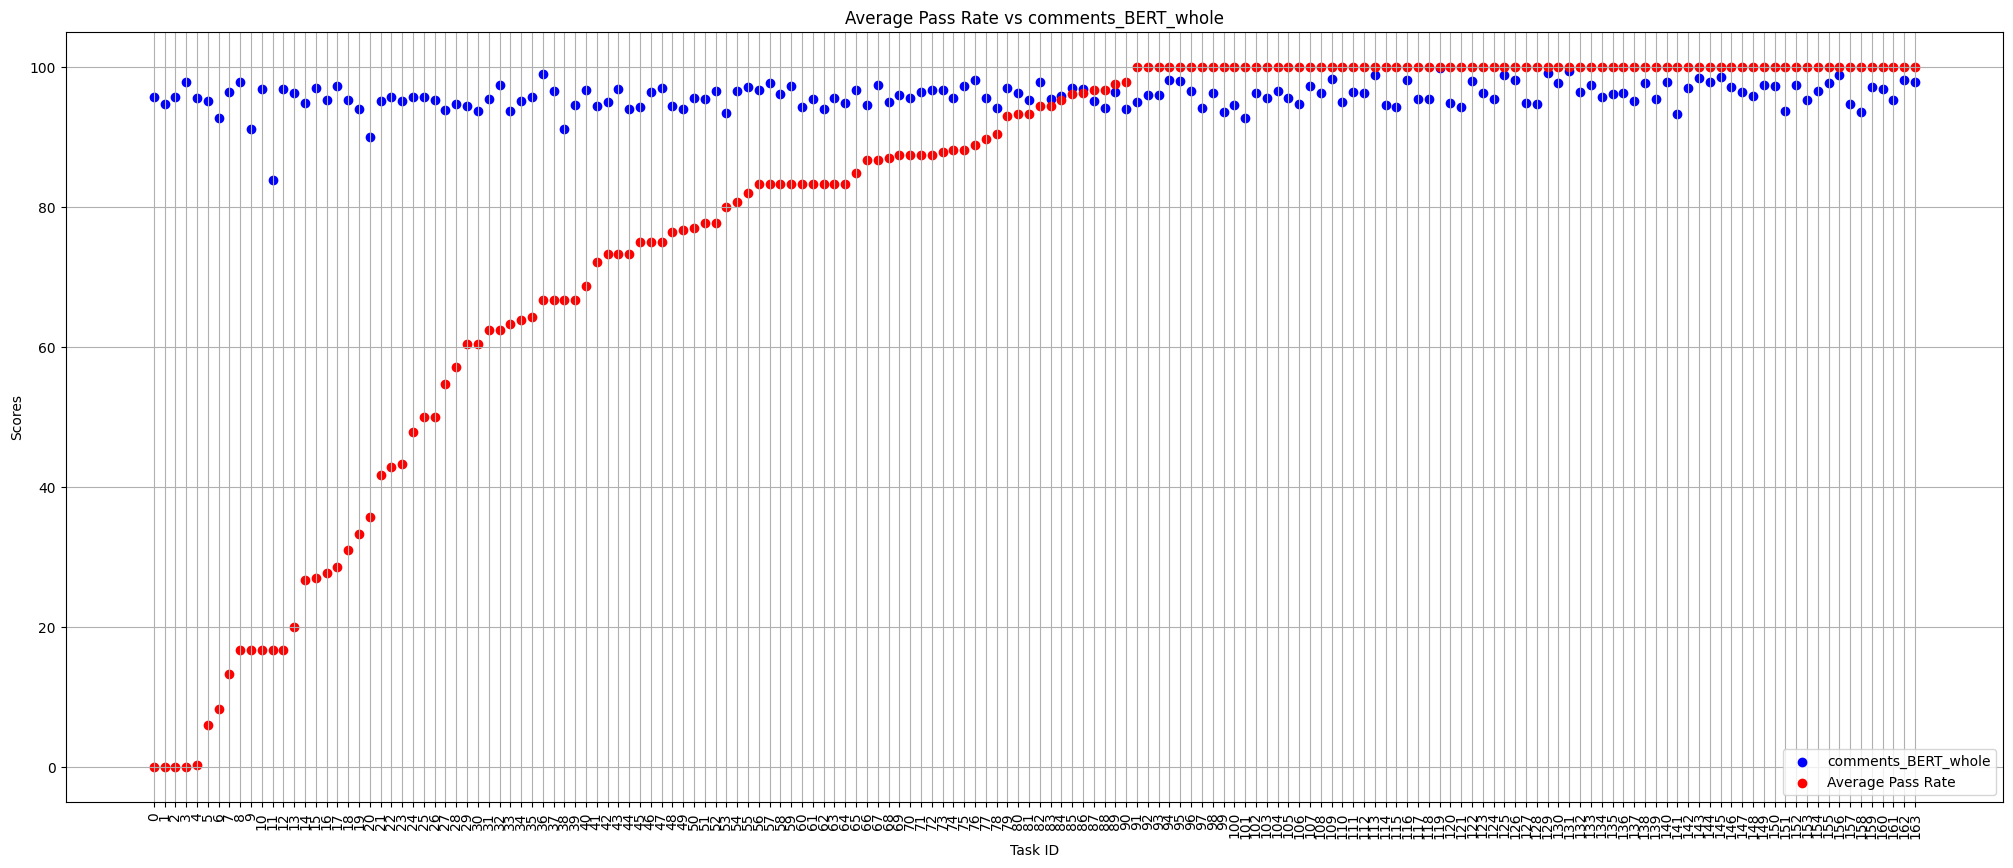

In [ ]:
corrs=-2

print("The correlation between the average pass rate and","comments_BERT_whole","is",df['avg_pass_rate'].corr(df['comments_BERT_whole']))
if df['avg_pass_rate'].corr(df['comments_BERT_whole']) > corrs:
    corrs = df['avg_pass_rate'].corr(df['comments_BERT_whole'])

#plot the avg pass rate wih color red and sequence similarity with color blue
plt.figure(figsize=(25,10))
plt.scatter(df["task_id"],df['comments_BERT_whole']*100,color='blue')
plt.scatter(df["task_id"],df['avg_pass_rate'],color='red')
plt.xlabel('Task ID')
#rotate the x axis labels
plt.xticks(ticks = [i for i in range(len(df))],labels = [i for i in range(len(df))], rotation=90)
plt.ylabel('Scores')
plt.legend(['comments_BERT_whole','Average Pass Rate'])
plt.title('Average Pass Rate vs ' + 'comments_BERT_whole')
plt.grid()
plt.show()

The correlation between the average pass rate and comments_BERT_splitted is 0.279760487447761


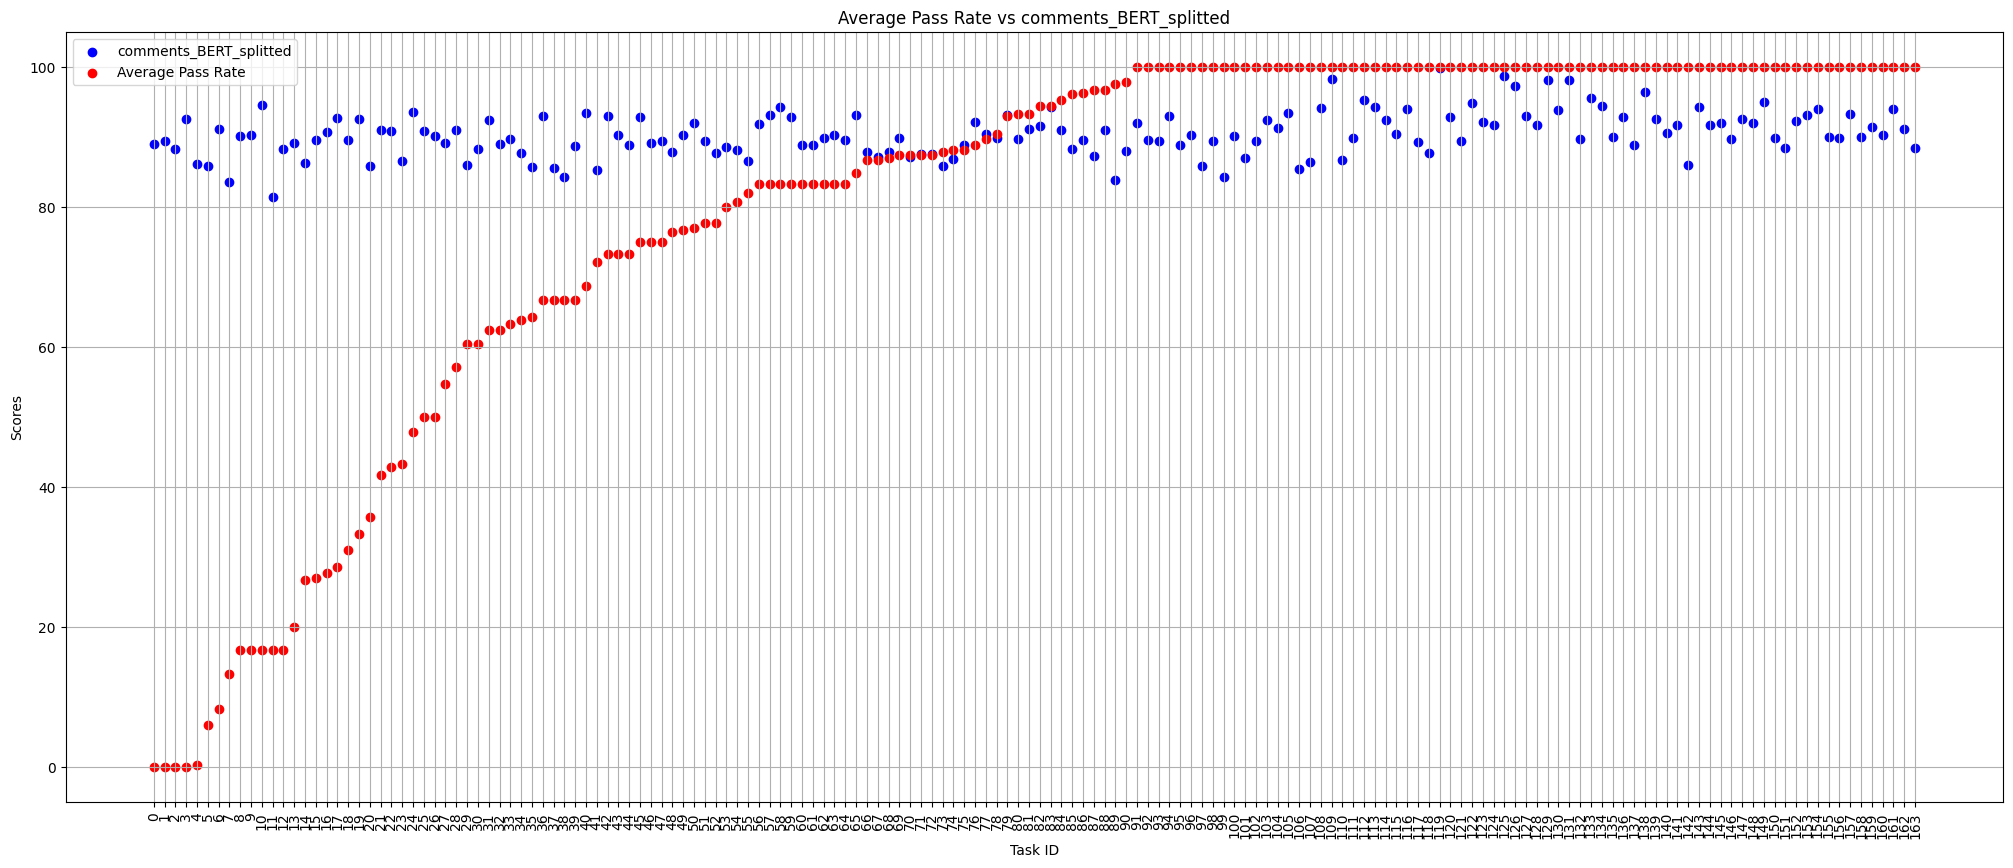

In [ ]:
corrs=-2

print("The correlation between the average pass rate and","comments_BERT_splitted","is",df['avg_pass_rate'].corr(df['comments_BERT_splitted']))
if df['avg_pass_rate'].corr(df['comments_BERT_splitted']) > corrs:
    corrs = df['avg_pass_rate'].corr(df['comments_BERT_splitted'])

#plot the avg pass rate wih color red and sequence similarity with color blue
plt.figure(figsize=(25,10))
plt.scatter(df["task_id"],df['comments_BERT_splitted']*100,color='blue')
plt.scatter(df["task_id"],df['avg_pass_rate'],color='red')
plt.xlabel('Task ID')
#rotate the x axis labels
plt.xticks(ticks = [i for i in range(len(df))],labels = [i for i in range(len(df))], rotation=90)
plt.ylabel('Scores')
plt.legend(['comments_BERT_splitted','Average Pass Rate'])
plt.title('Average Pass Rate vs ' + 'comments_BERT_splitted')
plt.grid()
plt.show()

The correlation between the average pass rate and comments_MNLI_whole is 0.09347339629771739


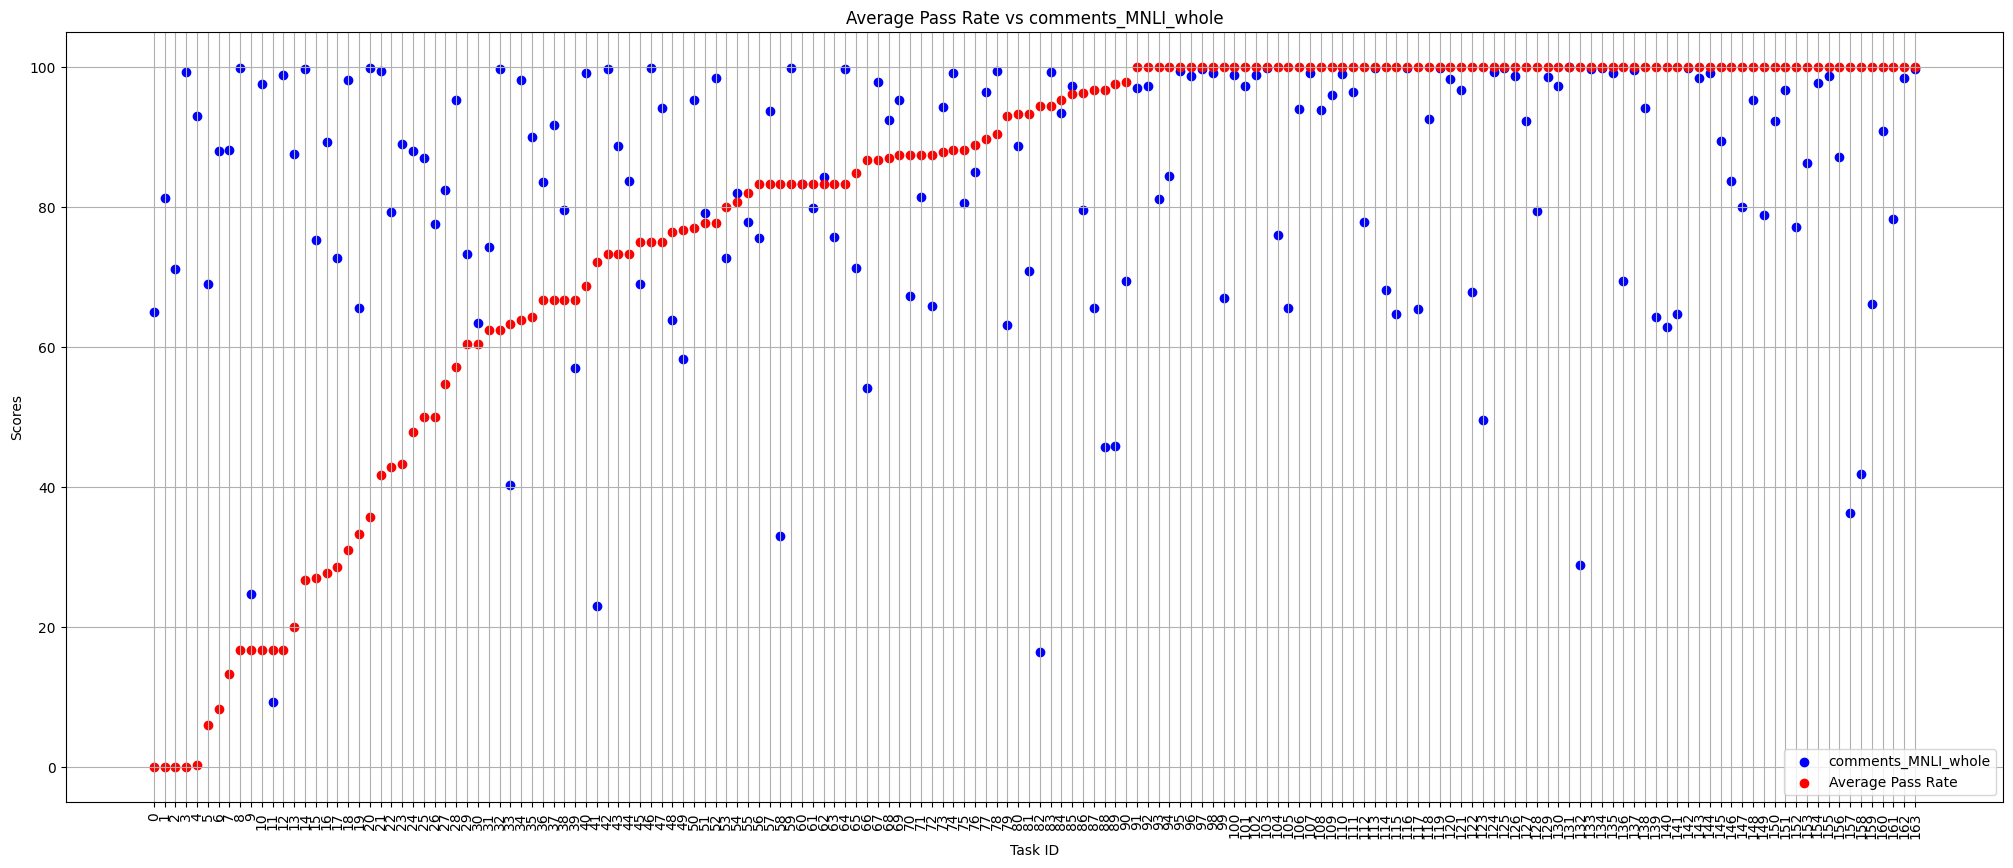

In [ ]:
corrs=-2

print("The correlation between the average pass rate and","comments_MNLI_whole","is",df['avg_pass_rate'].corr(df['comments_MNLI_whole']))
if df['avg_pass_rate'].corr(df['comments_MNLI_whole']) > corrs:
    corrs = df['avg_pass_rate'].corr(df['comments_MNLI_whole'])

#plot the avg pass rate wih color red and sequence similarity with color blue
plt.figure(figsize=(25,10))
plt.scatter(df["task_id"],df['comments_MNLI_whole']*100,color='blue')
plt.scatter(df["task_id"],df['avg_pass_rate'],color='red')
plt.xlabel('Task ID')
#rotate the x axis labels
plt.xticks(ticks = [i for i in range(len(df))],labels = [i for i in range(len(df))], rotation=90)
plt.ylabel('Scores')
plt.legend(['comments_MNLI_whole','Average Pass Rate'])
plt.title('Average Pass Rate vs ' + 'comments_MNLI_whole')
plt.grid()
plt.show()

The correlation between the average pass rate and comments_MNLI_splitted is 0.11683707445228904


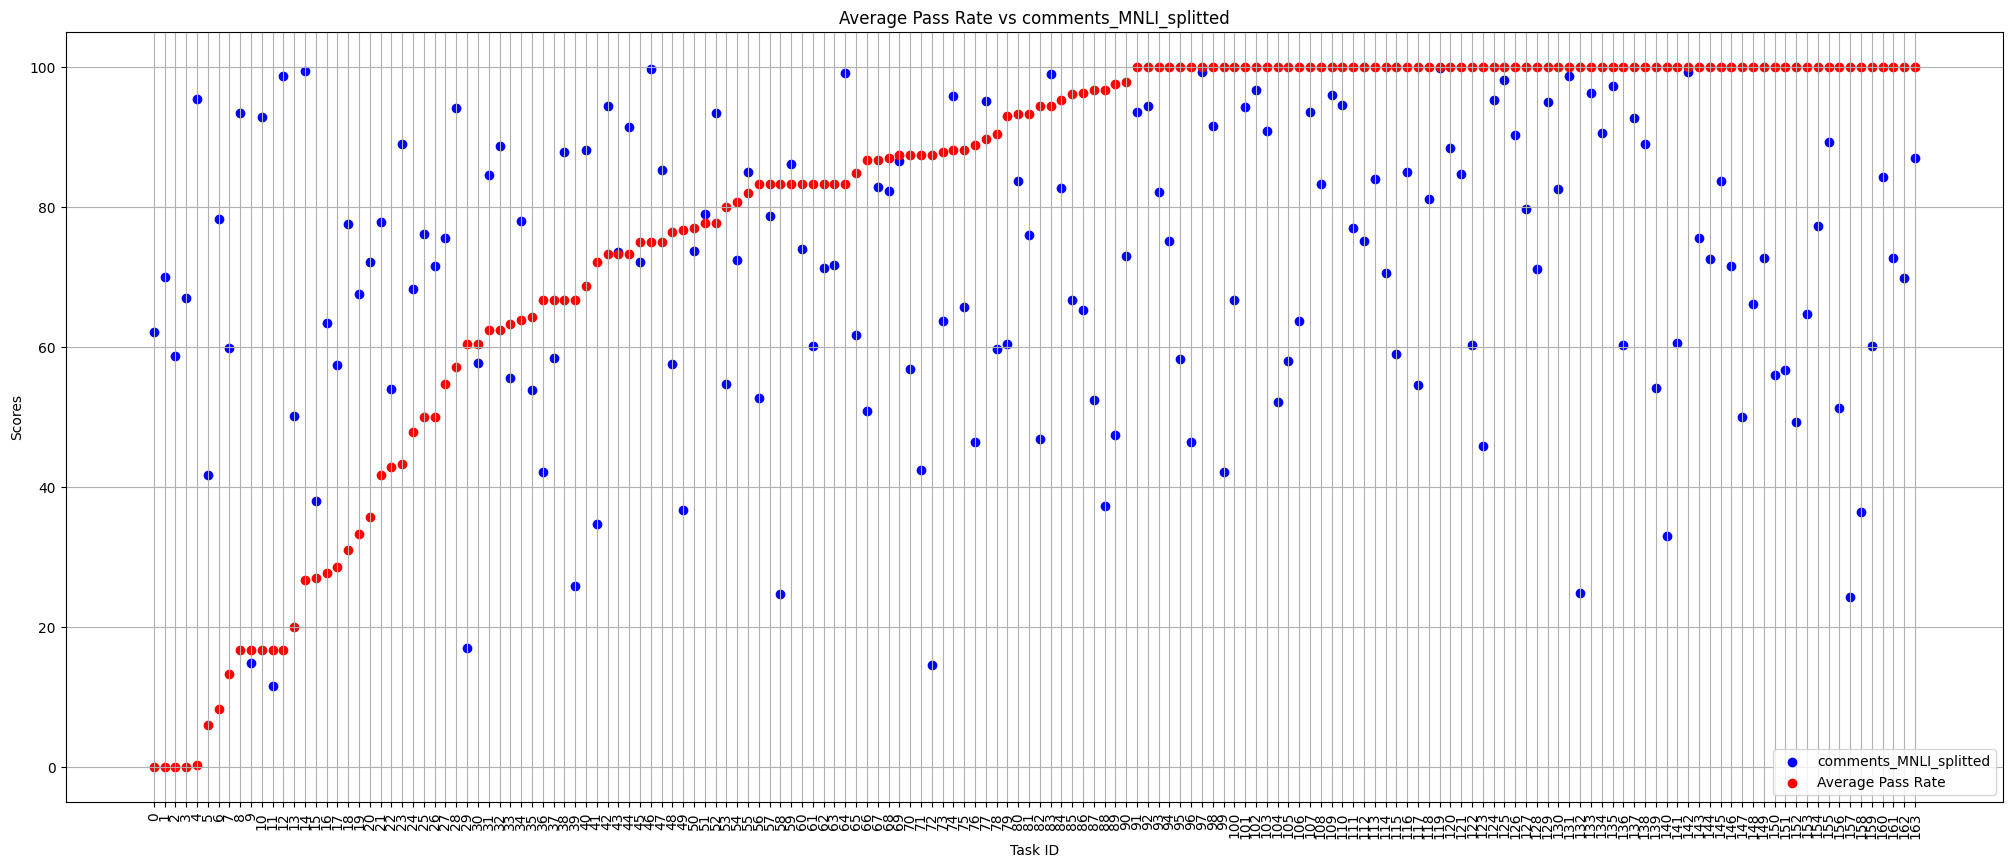

In [ ]:
corrs=-2

print("The correlation between the average pass rate and","comments_MNLI_splitted","is",df['avg_pass_rate'].corr(df['comments_MNLI_splitted']))
if df['avg_pass_rate'].corr(df['comments_MNLI_splitted']) > corrs:
    corrs = df['avg_pass_rate'].corr(df['comments_MNLI_splitted'])

#plot the avg pass rate wih color red and sequence similarity with color blue
plt.figure(figsize=(25,10))
plt.scatter(df["task_id"],df['comments_MNLI_splitted']*100,color='blue')
plt.scatter(df["task_id"],df['avg_pass_rate'],color='red')
plt.xlabel('Task ID')
#rotate the x axis labels
plt.xticks(ticks = [i for i in range(len(df))],labels = [i for i in range(len(df))], rotation=90)
plt.ylabel('Scores')
plt.legend(['comments_MNLI_splitted','Average Pass Rate'])
plt.title('Average Pass Rate vs ' + 'comments_MNLI_splitted')
plt.grid()
plt.show()

In [ ]:
df.loc[((df['comments_MNLI_splitted'] - df['avg_pass_rate']) >= 0.6)]

,task_id,prompt,code_0,code_1,code_2,code_3,code_4,code_5,pass_rate_0,pass_rate_1,...,gpt-3.5-turbo_comment_1,gpt-3.5-turbo_comment_2,gpt-3.5-turbo_comment_3,gpt-3.5-turbo_comment_4,gpt-3.5-turbo_comment_5,comments_BERT_whole,comments_BERT_splitted,comments_MNLI_whole,comments_MNLI_splitted,avg_pass_rate
38,HumanEval/38,"\n\ndef encode_cyclic(s: str):\n """"""\n r...",\ndef encode_cyclic(s: str):\n groups = [s[...,"\ndef encode_cyclic(s: str):\n """"""\n ret...","\ndef encode_cyclic(s: str):\n """"""\n ret...","\ndef encode_cyclic(s: str):\n """"""\n ret...",\nfrom typing import List\n\ndef encode_cyclic...,\nfrom typing import List\n\ndef encode_cyclic...,0.0,0.0,...,This Python code defines two functions - `enco...,This Python code defines two functions - `enco...,The `encode_cyclic` function takes a string as...,This Python code defines two functions: `encod...,This code snippet defines two functions: `enco...,0.957278,0.889449,0.649510,0.621942,0.000000
130,HumanEval/130,"\ndef tri(n):\n """"""Everyone knows Fibonacci...",\ndef tri(n):\n if n == 0:\n return ...,\ndef tri(n):\n seq = [3]\n if n == 0:\n...,\ndef tri(n):\n tribonacci_sequence = [3]\n...,"\ndef tri(n):\n tri_seq = [0, 1, 1]\n\n ...",\ndef tri(n):\n tribonacci_sequence = [3] i...,\ndef tri(n):\n if n == 0:\n return ...,0.0,0.0,...,This Python code defines a function `tri(n)` t...,This Python code defines a function `tri` that...,This Python code defines a function called `tr...,This Python code generates a tribonacci sequen...,This Python code defines a function that gener...,0.946731,0.893836,0.813153,0.700741,0.000000
113,HumanEval/113,"\ndef odd_count(lst):\n """"""Given a list of ...",\nfrom typing import List\n\ndef odd_count(lst...,\nfrom typing import List\n\ndef odd_count(lst...,\nfrom typing import List\n\ndef odd_count(lst...,\nfrom typing import List\n\ndef odd_count(lst...,\nfrom typing import List\n\ndef odd_count(lst...,\nfrom typing import List\n\ndef odd_count(lst...,0.0,0.0,...,This Python code defines a function that takes...,This Python code defines a function called `od...,This Python code defines a function called `od...,This Python code takes a list of strings as in...,This Python code defines a function called `od...,0.978856,0.925925,0.992643,0.670528,0.000000
32,HumanEval/32,"import math\n\n\ndef poly(xs: list, x: float):...","\nimport math\n\ndef poly(xs: list, x: float):...","\nimport math\n\n\ndef poly(xs: list, x: float...","\nimport math\n\ndef poly(xs: list, x: float):...","\nimport math\n\n\ndef poly(xs: list, x: float...","\nimport math\n\ndef poly(xs: list, x: float):...","\nimport math\n\ndef poly(xs: list, x: float):...",0.0,0.0,...,This Python code defines two functions. The `p...,This Python code defines a function to evaluat...,The code defines two functions:\n1. `poly(xs: ...,This Python code defines two functions:\n1. `p...,The provided Python code includes two function...,0.955287,0.861594,0.929676,0.955041,0.333333


In [ ]:
print(df[[f'gpt-3.5-turbo_comment_{i}' for i in range(6)]].iloc[38][0], "\n")
print(df[[f'gpt-3.5-turbo_comment_{i}' for i in range(6)]].iloc[38][1], "\n")
print(df[[f'gpt-3.5-turbo_comment_{i}' for i in range(6)]].iloc[38][2], "\n")
print(df[[f'gpt-3.5-turbo_comment_{i}' for i in range(6)]].iloc[38][3], "\n")
print(df[[f'gpt-3.5-turbo_comment_{i}' for i in range(6)]].iloc[38][4], "\n")
print(df[[f'gpt-3.5-turbo_comment_{i}' for i in range(6)]].iloc[38][5], "\n")

This Python function simulates an action where a certain number of carrots are eaten based on specific conditions of availability. It calculates the total number of carrots eaten and the amount of carrots left after eating based on the input parameters provided. 

This Python function calculates the total amount of something consumed based on the current amount, the amount needed, and the remaining amount. If after consuming the remaining amount, the total meets or exceeds the needed amount, it returns the total consumed and the updated remaining amount. Otherwise, it returns the total consumed and 0 as the remaining amount. 

This Python code defines a function called `eat` that takes three parameters: `number`, `need`, and `remaining`. The function calculates the total number of carrots by adding `number` and `need`. Then, it checks if the total number of carrots is less than or equal to the remaining carrots. If it is, it returns a list containing the updated total and the remaining

In [ ]:
df.loc[((df['avg_pass_rate']/100 - df['comments_MNLI_splitted']) >= 0.6)]

,task_id,prompt,code_0,code_1,code_2,code_3,code_4,code_5,pass_rate_0,pass_rate_1,...,gpt-3.5-turbo_comment_1,gpt-3.5-turbo_comment_2,gpt-3.5-turbo_comment_3,gpt-3.5-turbo_comment_4,gpt-3.5-turbo_comment_5,comments_BERT_whole,comments_BERT_splitted,comments_MNLI_whole,comments_MNLI_splitted,avg_pass_rate
68,HumanEval/68,"\ndef pluck(arr):\n """"""\n ""Given an arra...",\ndef pluck(arr):\n even_values = [num for ...,"\ndef pluck(arr):\n even_nodes = [(val, idx...","\ndef pluck(arr):\n even_values = [(num, id...","\ndef pluck(arr):\n evens = [(num, idx) for...",\ndef pluck(arr):\n even_values = [x for x ...,"\ndef pluck(arr):\n even_nodes = [(val, idx...",100.0,25.0,...,The function `pluck` takes a list of integers ...,This Python function tracks down the minimum e...,This Python code defines a function `pluck` th...,This Python code defines a function `pluck` th...,This code defines a function called `pluck` th...,0.967882,0.875345,0.659163,0.146113,87.5
27,HumanEval/27,"\n\ndef flip_case(string: str) -> str:\n """"...","\ndef flip_case(string: str) -> str:\n """""" ...","\ndef flip_case(string: str) -> str:\n """""" ...","\ndef flip_case(string: str) -> str:\n """""" ...",\ndef flip_case(string: str) -> str:\n retu...,"\ndef flip_case(string: str) -> str:\n """""" ...","\ndef flip_case(string: str) -> str:\n """""" ...",100.0,100.0,...,This Python function takes a string as input a...,This code defines a function called `flip_case...,This Python function takes a string as input a...,This Python function `flip_case` takes a strin...,This Python function takes a string as input a...,0.963895,0.896864,0.289115,0.248654,100.0
104,HumanEval/104,"\ndef unique_digits(x):\n """"""Given a list o...",\nfrom typing import List\n\ndef unique_digits...,\nfrom typing import List\n\ndef unique_digits...,\nfrom typing import List\n\ndef unique_digits...,\nfrom typing import List\n\ndef unique_digits...,\nfrom typing import List\n\ndef unique_digits...,\nfrom typing import List\n\ndef unique_digits...,100.0,100.0,...,This Python code defines a function named `uni...,This Python code defines a function called `un...,This Python code defines a function called `un...,This Python code defines a function `unique_di...,This Python code defines a function called `un...,0.977998,0.905911,0.628821,0.329540,100.0
66,HumanEval/66,"\ndef digitSum(s):\n """"""Task\n Write a f...",\ndef digitSum(s):\n return sum(ord(char) f...,\ndef digitSum(s):\n return sum(ord(char) f...,\ndef digitSum(s):\n return sum(ord(c) for ...,\ndef digitSum(s):\n return sum(ord(c) for ...,\ndef digitSum(s):\n return sum(ord(c) for ...,\ndef digitSum(s):\n return sum(ord(char) f...,100.0,100.0,...,This Python function takes a string as input a...,This Python function calculates the sum of ASC...,This Python code defines a function called `di...,This Python function calculates the sum of the...,This Python function calculates the sum of the...,0.946888,0.932912,0.363060,0.242987,100.0
63,HumanEval/63,"\n\ndef fibfib(n: int):\n """"""The FibFib num...",\nfrom functools import lru_cache\n\n@lru_cach...,\ndef fibfib(n: int) -> int:\n fib_values =...,\nfrom functools import lru_cache\n\n@lru_cach...,\ndef fibfib(n: int):\n if n == 0 or n == 1...,\nfrom functools import lru_cache\n\n@lru_cach...,\ndef fibfib(n: int):\n if n == 0 or n == 1...,100.0,100.0,...,This Python code defines a function called `fi...,This Python code defines a function `fibfib` t...,This Python code defines a function `fibfib` t...,This Python code defines a function `fibfib` t...,This Python code defines a function called `fi...,0.935805,0.899703,0.418357,0.363718,100.0


In [ ]:
print(df[[f'gpt-3.5-turbo_comment_{i}' for i in range(6)]].iloc[27][0], "\n")
print(df[[f'gpt-3.5-turbo_comment_{i}' for i in range(6)]].iloc[27][1], "\n")
print(df[[f'gpt-3.5-turbo_comment_{i}' for i in range(6)]].iloc[27][2], "\n")
print(df[[f'gpt-3.5-turbo_comment_{i}' for i in range(6)]].iloc[27][3], "\n")
print(df[[f'gpt-3.5-turbo_comment_{i}' for i in range(6)]].iloc[27][4], "\n")
print(df[[f'gpt-3.5-turbo_comment_{i}' for i in range(6)]].iloc[27][5], "\n")

This code checks if a given string has properly nested square brackets ('[]'). It simulates a stack structure to keep track of opening and closing brackets and returns True if the brackets are properly nested, and False otherwise. 

This Python code defines a function `is_nested` that checks if the given string has properly nested square brackets. The function counts the number of opening brackets `[` and matches them with closing brackets `]`. The function returns True if the brackets are properly nested, otherwise False. The provided test cases demonstrate the function execution on different input strings. 

This code defines a function called `is_nested` that checks if the brackets in a given string are properly nested or not. The function iterates through each character in the string, using a stack to keep track of opening brackets ('[') encountered. If a closing bracket (']') is encountered, it checks if there is a matching opening bracket at the top of the stack. Finally, it retu

In [ ]:
generated_comments = [
    "This code checks if a given string has properly nested square brackets ('[]'). It simulates a stack structure to keep track of opening and closing brackets and returns True if the brackets are properly nested, and False otherwise.",
    "This Python code defines a function `is_nested` that checks if the given string has properly nested square brackets. The function counts the number of opening brackets `[` and matches them with closing brackets `]`. The function returns True if the brackets are properly nested, otherwise False. The provided test cases demonstrate the function execution on different input strings.",
    "This code defines a function called `is_nested` that checks if the brackets in a given string are properly nested or not. The function iterates through each character in the string, using a stack to keep track of opening brackets ('[') encountered. If a closing bracket (']') is encountered, it checks if there is a matching opening bracket at the top of the stack. Finally, it returns a boolean value indicating whether the brackets are properly nested or not.",
    "This code defines a function `is_nested` that checks if the brackets in a given string are properly nested. It utilizes a stack to keep track of opening brackets and removes a pair of matching opening and closing bracket when found. The function returns `True` if the brackets are properly nested, otherwise it returns `False`.",
    "This code defines a function `is_nested` that checks whether the brackets in a given string are properly nested or not. ",
    "This Python code checks if the given string contains properly nested square brackets."
]
_, semantics_similarity,_ = semantics_similarity_driver(generated_comments)
#1 - semantics_similarity
1 - semantics_similarity['MNLI_Bart']

{'bert_score': 0.9390241265296936, 'MNLI_Bart': 0.8246405757963657}

0.17535942420363426

# BART Graphs

The correlation between the average pass rate and comments_BERT_whole is 0.2816749325267223


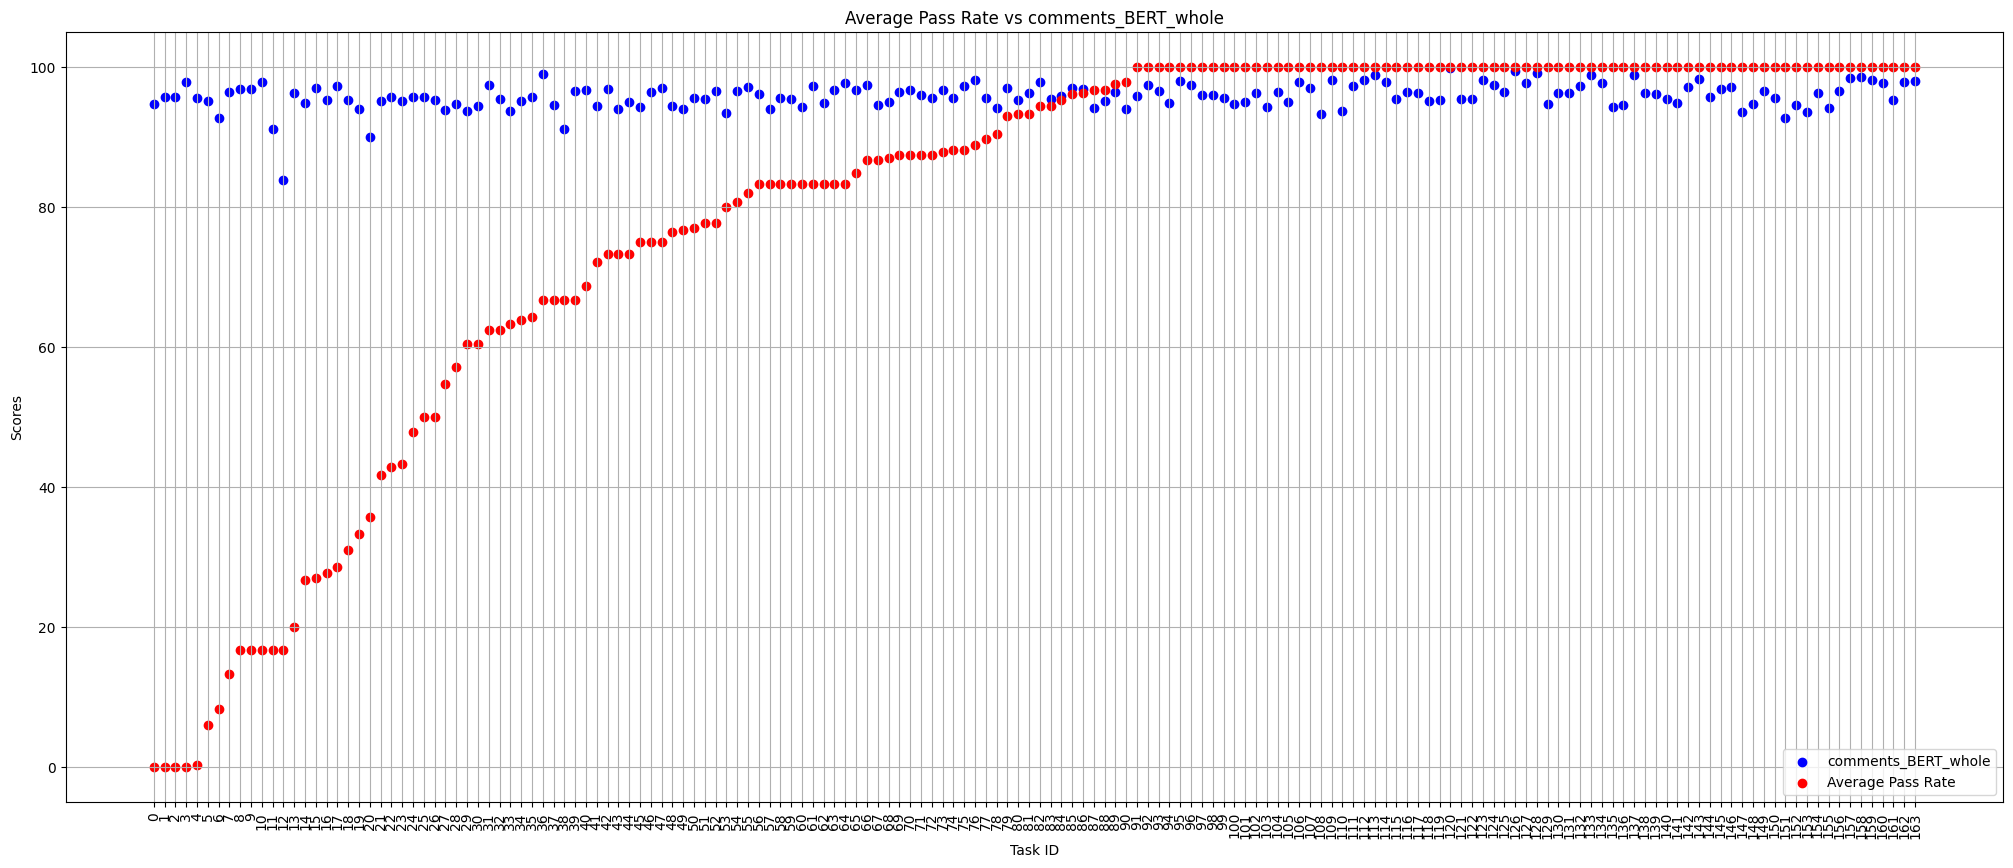

In [ ]:
corrs=-2

print("The correlation between the average pass rate and","comments_BERT_whole","is",df['avg_pass_rate'].corr(df['comments_BERT_whole']))
if df['avg_pass_rate'].corr(df['comments_BERT_whole']) > corrs:
    corrs = df['avg_pass_rate'].corr(df['comments_BERT_whole'])

#plot the avg pass rate wih color red and sequence similarity with color blue
plt.figure(figsize=(25,10))
plt.scatter(df["task_id"],df['comments_BERT_whole']*100,color='blue')
plt.scatter(df["task_id"],df['avg_pass_rate'],color='red')
plt.xlabel('Task ID')
#rotate the x axis labels
plt.xticks(ticks = [i for i in range(len(df))],labels = [i for i in range(len(df))], rotation=90)
plt.ylabel('Scores')
plt.legend(['comments_BERT_whole','Average Pass Rate'])
plt.title('Average Pass Rate vs ' + 'comments_BERT_whole')
plt.grid()
plt.show()

The correlation between the average pass rate and comments_BERT_splitted is 0.279760451694975


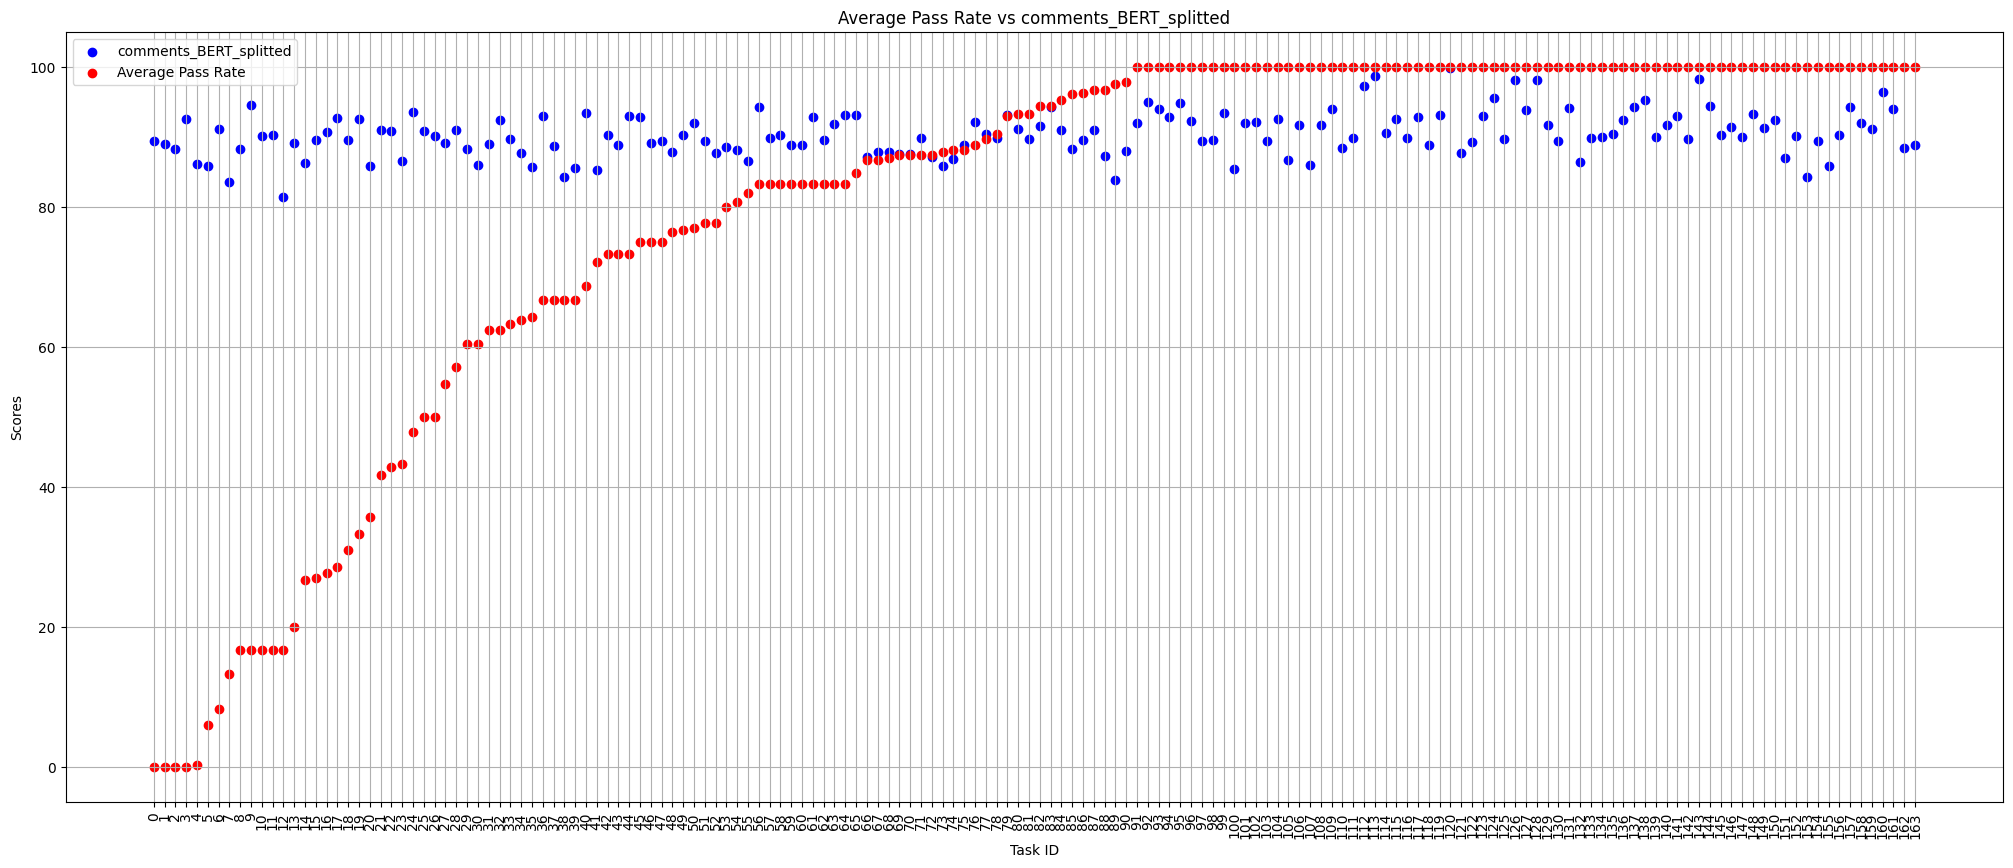

In [ ]:
corrs=-2

print("The correlation between the average pass rate and","comments_BERT_splitted","is",df['avg_pass_rate'].corr(df['comments_BERT_splitted']))
if df['avg_pass_rate'].corr(df['comments_BERT_splitted']) > corrs:
    corrs = df['avg_pass_rate'].corr(df['comments_BERT_splitted'])

#plot the avg pass rate wih color red and sequence similarity with color blue
plt.figure(figsize=(25,10))
plt.scatter(df["task_id"],df['comments_BERT_splitted']*100,color='blue')
plt.scatter(df["task_id"],df['avg_pass_rate'],color='red')
plt.xlabel('Task ID')
#rotate the x axis labels
plt.xticks(ticks = [i for i in range(len(df))],labels = [i for i in range(len(df))], rotation=90)
plt.ylabel('Scores')
plt.legend(['comments_BERT_splitted','Average Pass Rate'])
plt.title('Average Pass Rate vs ' + 'comments_BERT_splitted')
plt.grid()
plt.show()

The correlation between the average pass rate and comments_MNLI_whole is 0.26774131808370794


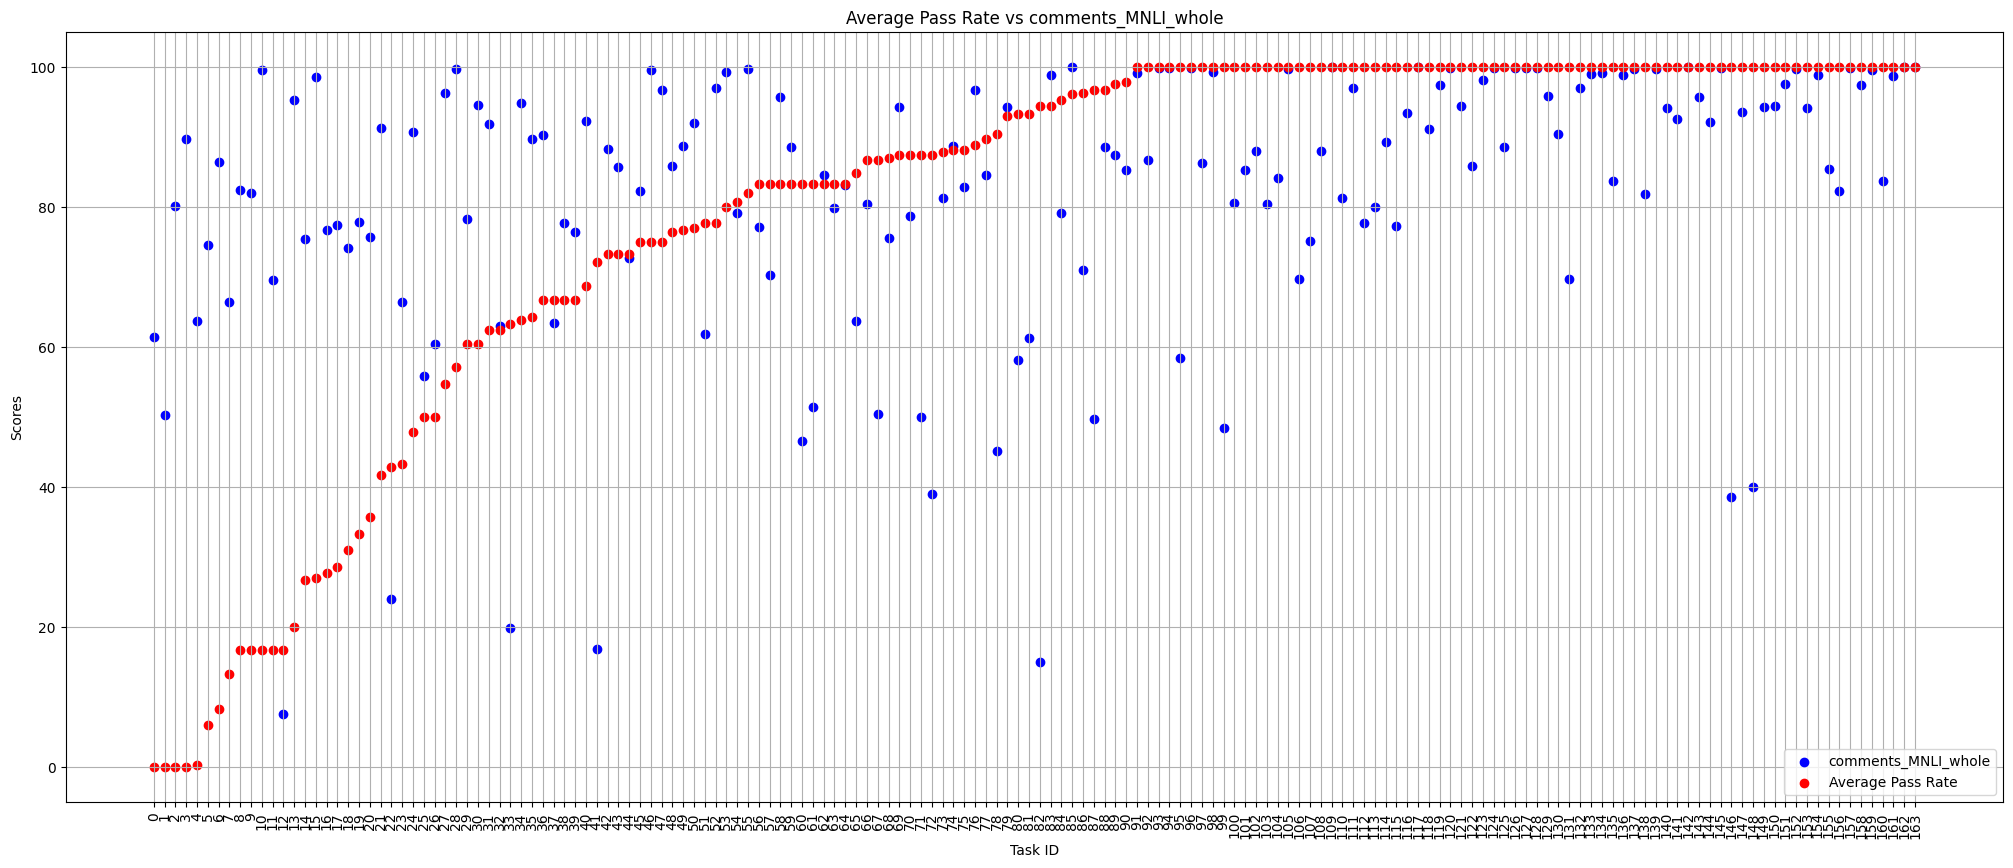

In [ ]:
corrs=-2

print("The correlation between the average pass rate and","comments_MNLI_whole","is",df['avg_pass_rate'].corr(df['comments_MNLI_whole']))
if df['avg_pass_rate'].corr(df['comments_MNLI_whole']) > corrs:
    corrs = df['avg_pass_rate'].corr(df['comments_MNLI_whole'])

#plot the avg pass rate wih color red and sequence similarity with color blue
plt.figure(figsize=(25,10))
plt.scatter(df["task_id"],df['comments_MNLI_whole']*100,color='blue')
plt.scatter(df["task_id"],df['avg_pass_rate'],color='red')
plt.xlabel('Task ID')
#rotate the x axis labels
plt.xticks(ticks = [i for i in range(len(df))],labels = [i for i in range(len(df))], rotation=90)
plt.ylabel('Scores')
plt.legend(['comments_MNLI_whole','Average Pass Rate'])
plt.title('Average Pass Rate vs ' + 'comments_MNLI_whole')
plt.grid()
plt.show()

The correlation between the average pass rate and comments_MNLI_splitted is 0.2649997342309642


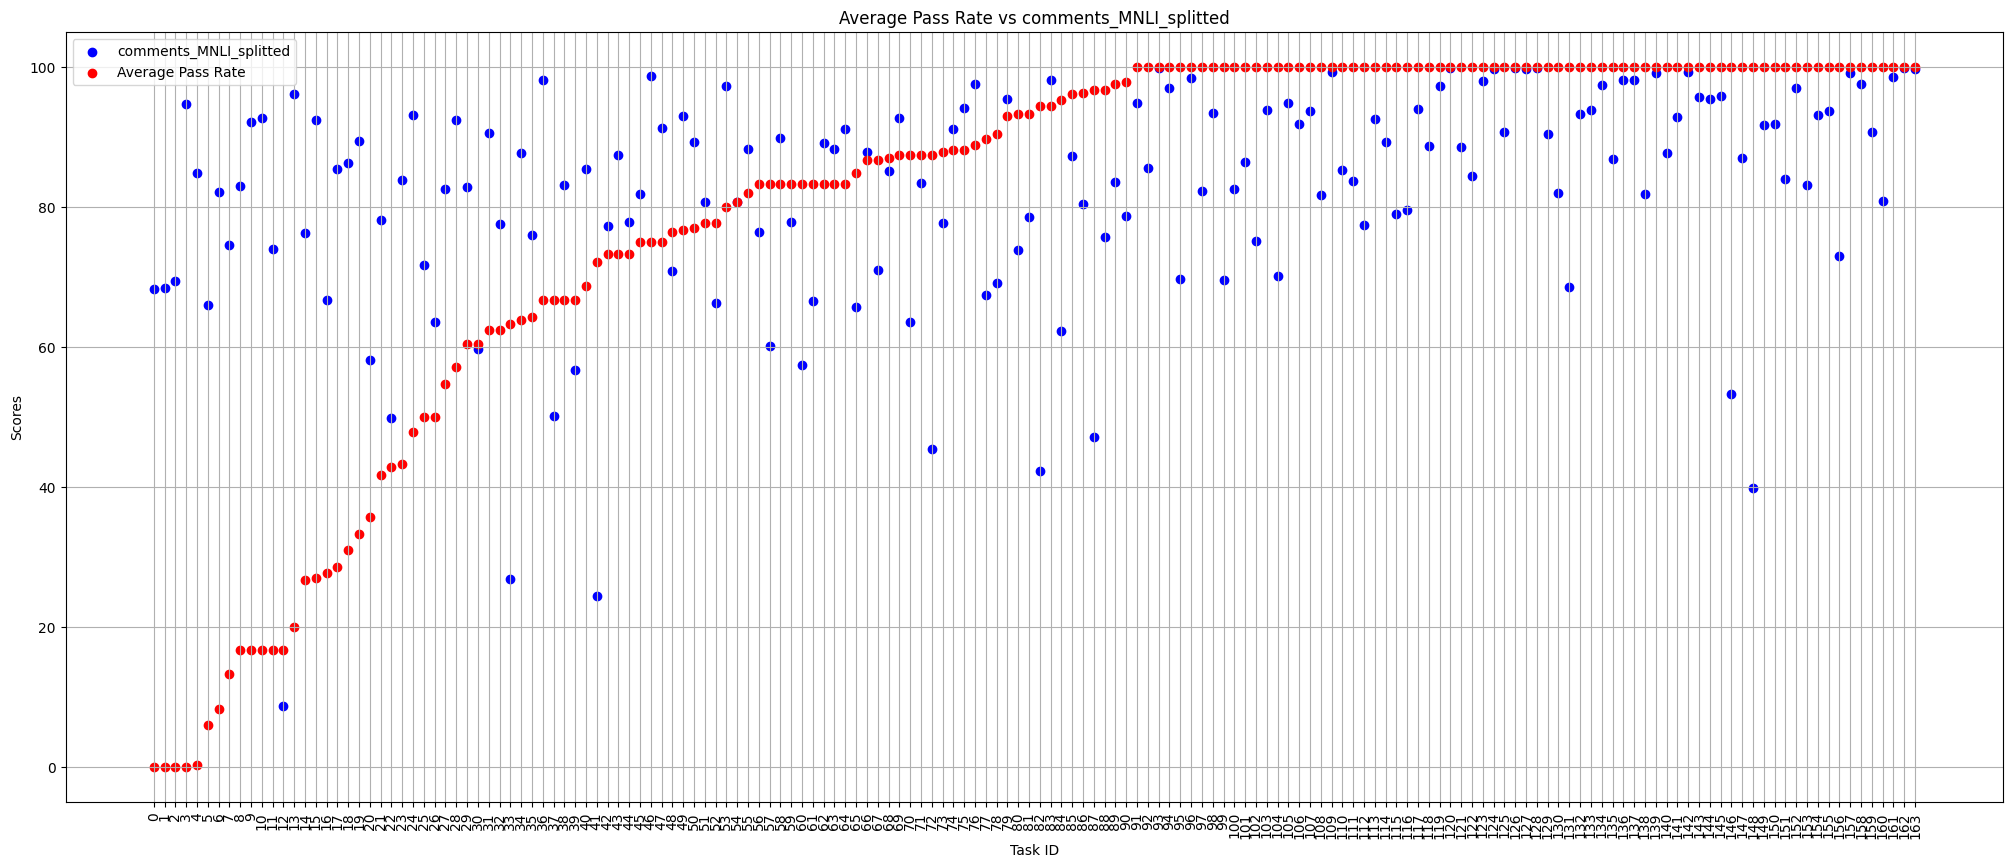

In [ ]:
corrs=-2

print("The correlation between the average pass rate and","comments_MNLI_splitted","is",df['avg_pass_rate'].corr(df['comments_MNLI_splitted']))
if df['avg_pass_rate'].corr(df['comments_MNLI_splitted']) > corrs:
    corrs = df['avg_pass_rate'].corr(df['comments_MNLI_splitted'])

#plot the avg pass rate wih color red and sequence similarity with color blue
plt.figure(figsize=(25,10))
plt.scatter(df["task_id"],df['comments_MNLI_splitted']*100,color='blue')
plt.scatter(df["task_id"],df['avg_pass_rate'],color='red')
plt.xlabel('Task ID')
#rotate the x axis labels
plt.xticks(ticks = [i for i in range(len(df))],labels = [i for i in range(len(df))], rotation=90)
plt.ylabel('Scores')
plt.legend(['comments_MNLI_splitted','Average Pass Rate'])
plt.title('Average Pass Rate vs ' + 'comments_MNLI_splitted')
plt.grid()
plt.show()

# other graphs

In [ ]:
df = pd.read_csv("/content/comments_dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_0_temps_1_trial_1.csv")
df = df.drop(axis=1, columns=["Unnamed: 0"])
df.head()

,task_id,prompt,code_0,code_1,code_2,code_3,code_4,code_5,pass_rate_0,pass_rate_1,...,gpt-3.5-turbo_comment_0,gpt-3.5-turbo_comment_1,gpt-3.5-turbo_comment_2,gpt-3.5-turbo_comment_3,gpt-3.5-turbo_comment_4,gpt-3.5-turbo_comment_5,comments_BERT_whole,comments_BERT_splitted,comments_MNLI_whole,comments_MNLI_splitted
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,\nfrom typing import List\n\ndef has_close_ele...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\ndef has_close_ele...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\n\ndef has_close_e...,\nfrom typing import List\n\ndef has_close_ele...,100.0,100.0,...,This Python code defines a function `has_close...,This Python code defines a function `has_close...,This Python code defines a function that takes...,This Python code defines a function `has_close...,This code defines a function called `has_close...,This Python code defines a function `has_close...,0.978708,0.885032,0.999761,0.998901
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,\nfrom typing import List\n\n\ndef separate_pa...,\nfrom typing import List\n\ndef separate_pare...,\nfrom typing import List\n\ndef separate_pare...,\nfrom typing import List\n\ndef separate_pare...,\nfrom typing import List\n\n\ndef separate_pa...,\nfrom typing import List\n\n\ndef separate_pa...,100.0,0.0,...,This code defines a function to separate and r...,This Python code defines a function called `se...,The code defines a function that separates gro...,This Python function takes a string containing...,This code defines a function that takes a stri...,This Python code defines a function that separ...,0.948410,0.896314,0.845763,0.891428
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import floor\n\ndef truncate_numbe...,\nfrom math import modf\n\ndef truncate_number...,\nfrom math import floor\n\ndef truncate_numbe...,\ndef truncate_number(number: float) -> float:...,100.0,100.0,...,This Python code defines a function that takes...,This code defines a function called `truncate_...,This Python code defines a function called `tr...,This Python code defines a function `truncate_...,This Python code defines a function named `tru...,This Python function takes a float number as i...,0.955780,0.934091,0.484434,0.696102
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,\nfrom typing import List\n\ndef below_zero(op...,100.0,100.0,...,This Python code defines a function called `be...,This code defines a function called `below_zer...,The code checks if the cumulative sum of a lis...,This Python function determines if the running...,This Python function checks if the cumulative ...,This Python code defines a function called `be...,0.947319,0.853962,0.805708,0.825181
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\ndef mean_absolute...,\nfrom typing import List\n\n\ndef mean_absolu...,\nfrom typing import List\n\ndef mean_absolute...,100.0,100.0,...,This code defines a function `mean_absolute_de...,This Python code defines a function called `me...,This Python code defines a function `mean_abso...,This Python code defines a function called `me...,This Python code defines a function called `me...,This Python code defines a function that calcu...,0.950522,0.920845,0.852440,0.864719


In [ ]:
df2 = pd.read_csv("/content/dataset_HumanEval_model_gpt-3.5-turbo_n_5_tempr_0_temps_1_trial_1_sim_score.csv")
df2.head()

,task_id,prompt,sequence_similarity,edit_distance_score,jaccard_similarity,cosine_similarity_score,sorensen_dice_coefficient,hamming_distance_score,longest_common_subsequence,UnifiedDiff,TreeDiff,pass_rate_0,pass_rate_1,pass_rate_2,pass_rate_3,pass_rate_4,pass_rate_5
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,0.940556,0.861875,0.869799,0.922270,0.990873,0.515354,0.717147,0.617761,0.651163,100.0,100.0,100.0,100.0,100.0,100.0
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,0.836340,0.620736,0.558942,0.378719,0.983283,0.249174,0.153785,0.459821,0.490783,100.0,0.0,100.0,100.0,100.0,100.0
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,0.906068,0.740219,0.731667,0.792200,0.982417,0.530095,0.668986,0.690476,0.623377,100.0,100.0,100.0,100.0,100.0,100.0
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,0.895160,0.724068,0.743810,0.740619,0.985226,0.539661,0.507458,0.699248,0.683230,100.0,100.0,100.0,100.0,100.0,100.0
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,0.876134,0.671556,0.733165,0.849657,0.980530,0.544209,0.480805,0.619048,0.656250,100.0,100.0,100.0,100.0,100.0,100.0


In [ ]:
df = pd.merge(df, df2, on="task_id")
df["avg_pass_rate"] = df[[f'pass_rate_{i}_x' for i in range(6)]].sum(axis=1)/6
df["avg_pass_rate_y"] = df[[f'pass_rate_{i}_y' for i in range(6)]].sum(axis=1)/6
print(df["avg_pass_rate_y"].equals(df["avg_pass_rate"]))
df = df.sort_values(by='avg_pass_rate', ascending=True)
df.head()

True


,task_id,prompt_x,code_0,code_1,code_2,code_3,code_4,code_5,pass_rate_0_x,pass_rate_1_x,...,UnifiedDiff,TreeDiff,pass_rate_0_y,pass_rate_1_y,pass_rate_2_y,pass_rate_3_y,pass_rate_4_y,pass_rate_5_y,avg_pass_rate,avg_pass_rate_y
38,HumanEval/38,"\n\ndef encode_cyclic(s: str):\n """"""\n r...",\ndef encode_cyclic(s: str):\n groups = [s[...,"\ndef encode_cyclic(s: str):\n """"""\n ret...","\ndef encode_cyclic(s: str):\n """"""\n ret...","\ndef encode_cyclic(s: str):\n """"""\n ret...",\nfrom typing import List\n\ndef encode_cyclic...,\nfrom typing import List\n\ndef encode_cyclic...,0.0,0.0,...,0.685185,0.702544,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
130,HumanEval/130,"\ndef tri(n):\n """"""Everyone knows Fibonacci...",\ndef tri(n):\n if n == 0:\n return ...,\ndef tri(n):\n seq = [3]\n if n == 0:\n...,\ndef tri(n):\n tribonacci_sequence = [3]\n...,"\ndef tri(n):\n tri_seq = [0, 1, 1]\n\n ...",\ndef tri(n):\n tribonacci_sequence = [3] i...,\ndef tri(n):\n if n == 0:\n return ...,0.0,0.0,...,0.229167,0.562771,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
89,HumanEval/89,"\ndef encrypt(s):\n """"""Create a function en...",\nimport string\n\ndef encrypt(s):\n shifte...,"\nimport string\n\ndef encrypt(s):\n """"""Cre...",\nimport string\n\ndef encrypt(s):\n rotate...,\nimport string\n\ndef encrypt(s):\n shifte...,\nimport string\n\ndef encrypt(s):\n encryp...,\nfrom string import ascii_lowercase\n\ndef en...,0.0,0.0,...,0.500000,0.541528,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
113,HumanEval/113,"\ndef odd_count(lst):\n """"""Given a list of ...",\nfrom typing import List\n\ndef odd_count(lst...,\nfrom typing import List\n\ndef odd_count(lst...,\nfrom typing import List\n\ndef odd_count(lst...,\nfrom typing import List\n\ndef odd_count(lst...,\nfrom typing import List\n\ndef odd_count(lst...,\nfrom typing import List\n\ndef odd_count(lst...,0.0,0.0,...,0.481633,0.600529,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
32,HumanEval/32,"import math\n\n\ndef poly(xs: list, x: float):...","\nimport math\n\ndef poly(xs: list, x: float):...","\nimport math\n\n\ndef poly(xs: list, x: float...","\nimport math\n\ndef poly(xs: list, x: float):...","\nimport math\n\n\ndef poly(xs: list, x: float...","\nimport math\n\ndef poly(xs: list, x: float):...","\nimport math\n\ndef poly(xs: list, x: float):...",0.0,0.0,...,0.658537,0.581395,0.0,0.0,0.0,0.0,2.0,0.0,0.333333,0.333333


The correlation between the average pass rate and comments_MNLI_whole is 0.267741318083708


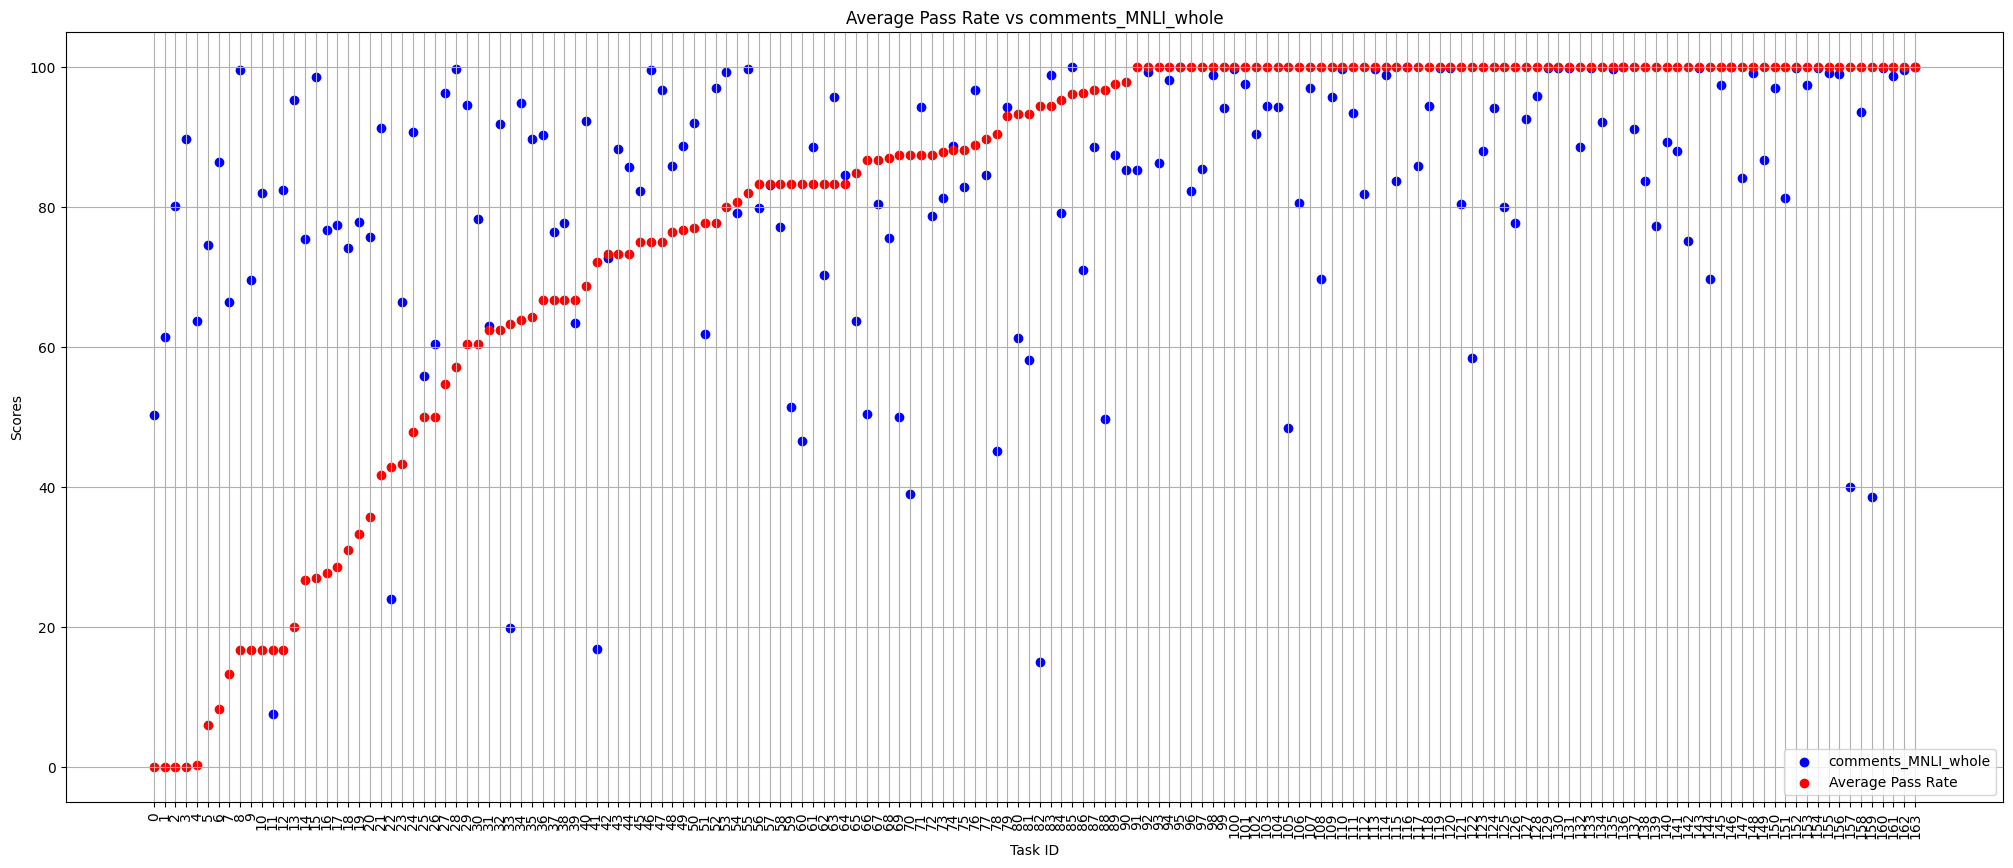

In [ ]:
corrs=-2

print("The correlation between the average pass rate and","comments_MNLI_whole","is",df['avg_pass_rate'].corr(df['comments_MNLI_whole']))
if df['avg_pass_rate'].corr(df['comments_MNLI_whole']) > corrs:
    corrs = df['avg_pass_rate'].corr(df['comments_MNLI_whole'])

#plot the avg pass rate wih color red and sequence similarity with color blue
plt.figure(figsize=(25,10))
plt.scatter(df["task_id"],df['comments_MNLI_whole']*100,color='blue')
plt.scatter(df["task_id"],df['avg_pass_rate'],color='red')
plt.xlabel('Task ID')
#rotate the x axis labels
plt.xticks(ticks = [i for i in range(len(df))],labels = [i for i in range(len(df))], rotation=90)
plt.ylabel('Scores')
plt.legend(['comments_MNLI_whole','Average Pass Rate'])
plt.title('Average Pass Rate vs ' + 'comments_MNLI_whole')
plt.grid()
plt.show()